In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import pymssql
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from xgboost import XGBRegressor
from sklearn import metrics

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_data():
    df = pd.DataFrame()
    try:
        con = pymssql.connect(user='username',password = 'password'
                 ,host='server',database='db',autocommit = True)
    except Exception as e:
        print('unable to make connection',e)
    cur=con.cursor()

    query = """
    -------------------------------------PAYMENTS AND CHARGES DATA----------------------------------
    ----------------------------charges data--------------------------------------
    IF OBJECT_ID('TEMPDB..#RCM_CHA') IS NOT NULL
    DROP TABLE #RCM_CHA
    Select pr.practice_code as Practice_Code,  MONTH(cc.DOE) as [Month], year(cc.DOE) as [Year],
    SUM(cc.Amount) as Charges_Sum
    into #RCM_CHA from Claim_Charges cc 
    join Claims c on
    cc.Claim_No = c.Claim_No and DATEDIFF(day, cc.DOE, GETDATE())<1200
    and isnull(c.Deleted,0)= 0 and isnull(cc.Deleted,0)= 0
    join Patient p on
    p.Patient_Account = c.Patient_Account
    and isnull(p.Deleted,0)= 0
    join PRACTICES pr on
    pr.Practice_Code = p.Practice_Code 
    AND ISNULL(P.DELETED,0)=0
    AND PR.IS_ACTIVE=1 AND ISNULL(PR.IS_TEST_PRACTICE,0)=0
    AND ISNULL(PR.EXCLUDE_FROM_BILLING_REPORTS,0) = 0
    AND PR.EMR_NAME NOT IN ('CHARTS PRO','PM STANDALONE','TESTINGPRACTICE')
    AND PR.PRACTICE_CODE NOT LIKE '9090%' AND PR.PRAC_NAME NOT LIKE '%TEST%'
    AND ISNULL(Pr.Deleted,0)=0
    group by pr.practice_code , MONTH(cc.DOE), YEAR(cc.DOE)
    -----------------------------------------------------------------------  
    ---------------------------------Payments data--------------------------------------
    IF OBJECT_ID('TEMPDB..#RCM_PAY') IS NOT NULL
    DROP TABLE #RCM_PAY
    Select pr.practice_code as Practice_Code,  MONTH(CP.Date_Entry) as [Month], year(CP.Date_Entry) as [Year],
    SUM(cp.Amount_Paid) as Paymnet_Sum
    into #RCM_PAY from Claim_Payments cp
    join Claims c on
    cP.Claim_No  = c.Claim_No and DATEDIFF(day, CP.Date_Entry, GETDATE())<1200
    and isnull(c.Deleted,0)= 0 and isnull(cp.Deleted,0)= 0
    join Patient p on
    p.Patient_Account = c.Patient_Account
    and isnull(p.Deleted,0)= 0
    join PRACTICES pr on
    pr.Practice_Code = p.Practice_Code 
    AND ISNULL(P.DELETED,0)=0
    AND PR.IS_ACTIVE=1 AND ISNULL(PR.IS_TEST_PRACTICE,0)=0
    AND ISNULL(PR.EXCLUDE_FROM_BILLING_REPORTS,0) = 0
    AND PR.EMR_NAME NOT IN ('CHARTS PRO','PM STANDALONE','TESTINGPRACTICE')
    AND PR.PRACTICE_CODE NOT LIKE '9090%' AND PR.PRAC_NAME NOT LIKE '%TEST%'
    AND ISNULL(Pr.Deleted,0)=0
    group by pr.practice_code , MONTH(cp.Date_Entry), YEAR(CP.Date_Entry)
    -----------------------------------------------------------------------
    IF OBJECT_ID('TEMPDB..#RCM_PCD') IS NOT NULL
    DROP TABLE #RCM_PCD
    Select C.practice_code, C.[Month],C.[Year],C.Charges_Sum,p.Paymnet_Sum
    into #RCM_PCD
    from #RCM_CHA C
    join #RCM_PAY P on
    c.Practice_Code = p.Practice_Code and c.[Month] = p.[Month] and c.[Year] = p.[Year]  
    -----------------------------------------------------------------------------------------------
    IF OBJECT_ID('TEMPDB..#RCM_DATA') IS NOT NULL
    DROP TABLE #RCM_DATA
    SELECT r.practice_code, r.[Month],r.[Year],r.Charges_Sum,r.Paymnet_Sum,
    a.AGING_0_30, a.AGING_31_60, a.AGING_61_90, a.AGING_91_120,a.AGING_120_PLUS  into #RCM_DATA
    from #RCM_PCD r
    left join MONTH_END_AGING a on
    r.practice_code = a.PRACTICE_CODE and r.[Year] = a.CLOSE_YEAR and  r.[Month] = a.CLOSE_MONTH 
    order by practice_code, YEAR, MONTH 
	------------------------------------------------------------------------------------------------------------
   	IF OBJECT_ID('TEMPDB..#RCM_PREV') IS NOT NULL
    DROP TABLE #RCM_PREV
    SELECT practice_code, Month,Year,Charges_Sum,
    COALESCE(lag(Charges_Sum) over (partition by PRACTICE_CODE order by [YEAR],[MONTH]), 0) as Prev_Month_Charges,
    Paymnet_Sum, 
    COALESCE(lag(Paymnet_Sum) over (partition by PRACTICE_CODE order by [YEAR],[MONTH]), 0) as Prev_Month_Payments,
    AGING_0_30, AGING_31_60, AGING_61_90, AGING_91_120,AGING_120_PLUS  into #RCM_PREV
    from #RCM_DATA
    -----------------------------------------------------------------------------------------------------------------
   	IF OBJECT_ID('TEMPDB..#RCM_FIN') IS NOT NULL
    DROP TABLE #RCM_FIN
    SELECT practice_code, Month,Year,Charges_Sum,Prev_Month_Charges,
    COALESCE(lag(Prev_Month_Charges) over (partition by PRACTICE_CODE order by [YEAR],[MONTH]), 0) as Prev_2nd_Month_Charges,
    Paymnet_Sum, Prev_Month_Payments,
    COALESCE(lag(Prev_Month_Payments) over (partition by PRACTICE_CODE order by [YEAR],[MONTH]), 0) as Prev_2nd_Month_Payments,
    AGING_0_30, AGING_31_60, AGING_61_90, AGING_91_120,AGING_120_PLUS  into #RCM_FIN
    from #RCM_PREV
    
    Select * from #RCM_FIN order by practice_code, YEAR, MONTH 
    ---------------------------------------------------------------------------------------------------------------------------

    
     
    """ 
    
    try:
        cur.execute(query)
        df=pd.DataFrame(cur.fetchall(),columns=[x[0] for x in cur.description])
        df.columns=df.columns.str.upper()
        con.close()
    except:
        print('Error in reading data.....')
        con.close()
    return df

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# df = get_data()

In [6]:
# df.to_csv("YEARLY_PAY_CHAR.CSV", index = False)

In [22]:
data = pd.read_csv("YEARLY_PAY_CHAR.CSV")

In [23]:
data_copy = data.copy()

In [24]:
# data_copy.to_excel("CHARGES_DATA_TRAINING.xlsx")

In [25]:
data.head()

,PRACTICE_CODE,MONTH,YEAR,CHARGES_SUM,PREV_MONTH_CHARGES,PREV_2ND_MONTH_CHARGES,PAYMNET_SUM,PREV_MONTH_PAYMENTS,PREV_2ND_MONTH_PAYMENTS,AGING_0_30,AGING_31_60,AGING_61_90,AGING_91_120,AGING_120_PLUS
0,100,1,2020,42146.17,0.00,0.00,8234.16,0.00,0.00,42561.52,11326.57,2097.54,2608.87,4403.1902
1,100,2,2020,105143.63,42146.17,0.00,29557.52,8234.16,0.00,49423.63,15254.00,6792.06,1655.89,4735.5202
2,100,3,2020,67294.84,105143.63,42146.17,33920.76,29557.52,8234.16,26190.32,11132.40,7345.34,3906.57,5615.0502
3,100,4,2020,29072.00,67294.84,105143.63,15143.49,33920.76,29557.52,16550.29,9962.74,10057.86,6453.90,7648.2502
4,100,5,2020,21518.43,29072.00,67294.84,17640.68,15143.49,33920.76,9051.62,4792.24,6801.58,6237.26,8401.3902


In [27]:
# data.columns

In [28]:
data['PC_RATIO'] = (data['PAYMNET_SUM']/data['CHARGES_SUM'])*100

In [29]:
data.fillna(0, inplace=True)
data.replace([np.inf, -np.inf], 0, inplace=True)

In [30]:
data = data.rename(columns = {'PRACTICE_CODE':'PRAC_CODE', 'CHARGES_SUM':'CHARG_SUM','PREV_MONTH_CHARGES':'PREV_M_CHARG','PREV_2ND_MONTH_CHARGES':'PREV_2ND_M_CHARG',
                      'PAYMNET_SUM':'PAY_SUM','PREV_MONTH_PAYMENTS':'PREV_M_PAY','PREV_2ND_MONTH_PAYMENTS':'PREV_2ND_M_PAY'})

In [31]:
data['PREV_3RD_M_CHARG'] = data.groupby('PRAC_CODE')['PREV_2ND_M_CHARG'].shift(1)
data['PREV_4TH_M_CHARG'] = data.groupby('PRAC_CODE')['PREV_3RD_M_CHARG'].shift(1)
data['PREV_5TH_M_CHARG'] = data.groupby('PRAC_CODE')['PREV_4TH_M_CHARG'].shift(1)
data['PREV_6TH_M_CHARG'] = data.groupby('PRAC_CODE')['PREV_5TH_M_CHARG'].shift(1)
data['PREV_7TH_M_CHARG'] = data.groupby('PRAC_CODE')['PREV_6TH_M_CHARG'].shift(1)
data['PREV_8TH_M_CHARG'] = data.groupby('PRAC_CODE')['PREV_7TH_M_CHARG'].shift(1)
data['PREV_9TH_M_CHARG'] = data.groupby('PRAC_CODE')['PREV_8TH_M_CHARG'].shift(1)
data['PREV_10TH_M_CHARG'] = data.groupby('PRAC_CODE')['PREV_9TH_M_CHARG'].shift(1)
data['PREV_11TH_M_CHARG'] = data.groupby('PRAC_CODE')['PREV_10TH_M_CHARG'].shift(1)
data['PREV_12TH_M_CHARG'] = data.groupby('PRAC_CODE')['PREV_11TH_M_CHARG'].shift(1)

In [32]:
data['PREV_3RD_M_PAY'] = data.groupby('PRAC_CODE')['PREV_2ND_M_PAY'].shift(1)
data['PREV_4TH_M_PAY'] = data.groupby('PRAC_CODE')['PREV_3RD_M_PAY'].shift(1)
data['PREV_5TH_M_PAY'] = data.groupby('PRAC_CODE')['PREV_4TH_M_PAY'].shift(1)
data['PREV_6TH_M_PAY'] = data.groupby('PRAC_CODE')['PREV_5TH_M_PAY'].shift(1)
data['PREV_7TH_M_PAY'] = data.groupby('PRAC_CODE')['PREV_6TH_M_PAY'].shift(1)
data['PREV_8TH_M_PAY'] = data.groupby('PRAC_CODE')['PREV_7TH_M_PAY'].shift(1)
data['PREV_9TH_M_PAY'] = data.groupby('PRAC_CODE')['PREV_8TH_M_PAY'].shift(1)
data['PREV_10TH_M_PAY'] = data.groupby('PRAC_CODE')['PREV_9TH_M_PAY'].shift(1)
data['PREV_11TH_M_PAY'] = data.groupby('PRAC_CODE')['PREV_10TH_M_PAY'].shift(1)
data['PREV_12TH_M_PAY'] = data.groupby('PRAC_CODE')['PREV_11TH_M_PAY'].shift(1)

In [33]:
data['PREV_M_AGING_0_30'] = data.groupby('PRAC_CODE')['AGING_0_30'].shift(1)
data['PREV_2M_AGING_0_30'] = data.groupby('PRAC_CODE')['PREV_M_AGING_0_30'].shift(1)
data['PREV_3M_AGING_0_30'] = data.groupby('PRAC_CODE')['PREV_2M_AGING_0_30'].shift(1)
data['PREV_4M_AGING_0_30'] = data.groupby('PRAC_CODE')['PREV_3M_AGING_0_30'].shift(1)
data['PREV_5M_AGING_0_30'] = data.groupby('PRAC_CODE')['PREV_4M_AGING_0_30'].shift(1)
data['PREV_6M_AGING_0_30'] = data.groupby('PRAC_CODE')['PREV_5M_AGING_0_30'].shift(1)
data['PREV_7M_AGING_0_30'] = data.groupby('PRAC_CODE')['PREV_6M_AGING_0_30'].shift(1)
data['PREV_8M_AGING_0_30'] = data.groupby('PRAC_CODE')['PREV_7M_AGING_0_30'].shift(1)
data['PREV_9M_AGING_0_30'] = data.groupby('PRAC_CODE')['PREV_8M_AGING_0_30'].shift(1)
data['PREV_10M_AGING_0_30'] = data.groupby('PRAC_CODE')['PREV_9M_AGING_0_30'].shift(1)
data['PREV_11M_AGING_0_30'] = data.groupby('PRAC_CODE')['PREV_10M_AGING_0_30'].shift(1)
data['PREV_12M_AGING_0_30'] = data.groupby('PRAC_CODE')['PREV_11M_AGING_0_30'].shift(1)

In [34]:
data['PREV_M_AGING_31_60'] = data.groupby('PRAC_CODE')['AGING_31_60'].shift(1)
data['PREV_2M_AGING_31_60'] = data.groupby('PRAC_CODE')['PREV_M_AGING_31_60'].shift(1)
data['PREV_3M_AGING_31_60'] = data.groupby('PRAC_CODE')['PREV_2M_AGING_31_60'].shift(1)
data['PREV_4M_AGING_31_60'] = data.groupby('PRAC_CODE')['PREV_3M_AGING_31_60'].shift(1)
data['PREV_5M_AGING_31_60'] = data.groupby('PRAC_CODE')['PREV_4M_AGING_31_60'].shift(1)
data['PREV_6M_AGING_31_60'] = data.groupby('PRAC_CODE')['PREV_5M_AGING_31_60'].shift(1)
data['PREV_7M_AGING_31_60'] = data.groupby('PRAC_CODE')['PREV_6M_AGING_31_60'].shift(1)
data['PREV_8M_AGING_31_60'] = data.groupby('PRAC_CODE')['PREV_7M_AGING_31_60'].shift(1)
data['PREV_9M_AGING_31_60'] = data.groupby('PRAC_CODE')['PREV_8M_AGING_31_60'].shift(1)
data['PREV_10M_AGING_31_60'] = data.groupby('PRAC_CODE')['PREV_9M_AGING_31_60'].shift(1)
data['PREV_11M_AGING_31_60'] = data.groupby('PRAC_CODE')['PREV_10M_AGING_31_60'].shift(1)
data['PREV_12M_AGING_31_60'] = data.groupby('PRAC_CODE')['PREV_11M_AGING_31_60'].shift(1)

In [35]:
data['PREV_M_AGING_61_90'] = data.groupby('PRAC_CODE')['AGING_61_90'].shift(1)
data['PREV_2M_AGING_61_90'] = data.groupby('PRAC_CODE')['PREV_M_AGING_61_90'].shift(1)
data['PREV_3M_AGING_61_90'] = data.groupby('PRAC_CODE')['PREV_2M_AGING_61_90'].shift(1)
data['PREV_4M_AGING_61_90'] = data.groupby('PRAC_CODE')['PREV_3M_AGING_61_90'].shift(1)
data['PREV_5M_AGING_61_90'] = data.groupby('PRAC_CODE')['PREV_4M_AGING_61_90'].shift(1)
data['PREV_6M_AGING_61_90'] = data.groupby('PRAC_CODE')['PREV_5M_AGING_61_90'].shift(1)
data['PREV_7M_AGING_61_90'] = data.groupby('PRAC_CODE')['PREV_6M_AGING_61_90'].shift(1)
data['PREV_8M_AGING_61_90'] = data.groupby('PRAC_CODE')['PREV_7M_AGING_61_90'].shift(1)
data['PREV_9M_AGING_61_90'] = data.groupby('PRAC_CODE')['PREV_8M_AGING_61_90'].shift(1)
data['PREV_10M_AGING_61_90'] = data.groupby('PRAC_CODE')['PREV_9M_AGING_61_90'].shift(1)
data['PREV_11M_AGING_61_90'] = data.groupby('PRAC_CODE')['PREV_10M_AGING_61_90'].shift(1)
data['PREV_12M_AGING_61_90'] = data.groupby('PRAC_CODE')['PREV_11M_AGING_61_90'].shift(1)

In [36]:
data['PREV_M_AGING_91_120'] = data.groupby('PRAC_CODE')['AGING_91_120'].shift(1)
data['PREV_2M_AGING_91_120'] = data.groupby('PRAC_CODE')['PREV_M_AGING_91_120'].shift(1)
data['PREV_3M_AGING_91_120'] = data.groupby('PRAC_CODE')['PREV_2M_AGING_91_120'].shift(1)
data['PREV_4M_AGING_91_120'] = data.groupby('PRAC_CODE')['PREV_3M_AGING_91_120'].shift(1)
data['PREV_5M_AGING_91_120'] = data.groupby('PRAC_CODE')['PREV_4M_AGING_91_120'].shift(1)
data['PREV_6M_AGING_91_120'] = data.groupby('PRAC_CODE')['PREV_5M_AGING_91_120'].shift(1)
data['PREV_7M_AGING_91_120'] = data.groupby('PRAC_CODE')['PREV_6M_AGING_91_120'].shift(1)
data['PREV_8M_AGING_91_120'] = data.groupby('PRAC_CODE')['PREV_7M_AGING_91_120'].shift(1)
data['PREV_9M_AGING_91_120'] = data.groupby('PRAC_CODE')['PREV_8M_AGING_91_120'].shift(1)
data['PREV_10M_AGING_91_120'] = data.groupby('PRAC_CODE')['PREV_9M_AGING_91_120'].shift(1)
data['PREV_11M_AGING_91_120'] = data.groupby('PRAC_CODE')['PREV_10M_AGING_91_120'].shift(1)
data['PREV_12M_AGING_91_120'] = data.groupby('PRAC_CODE')['PREV_11M_AGING_91_120'].shift(1)

In [37]:
data['PREV_M_AGING_120_PLUS'] = data.groupby('PRAC_CODE')['AGING_120_PLUS'].shift(1)
data['PREV_2M_AGING_120_PLUS'] = data.groupby('PRAC_CODE')['PREV_M_AGING_120_PLUS'].shift(1)
data['PREV_3M_AGING_120_PLUS'] = data.groupby('PRAC_CODE')['PREV_2M_AGING_120_PLUS'].shift(1)
data['PREV_4M_AGING_120_PLUS'] = data.groupby('PRAC_CODE')['PREV_3M_AGING_120_PLUS'].shift(1)
data['PREV_5M_AGING_120_PLUS'] = data.groupby('PRAC_CODE')['PREV_4M_AGING_120_PLUS'].shift(1)
data['PREV_6M_AGING_120_PLUS'] = data.groupby('PRAC_CODE')['PREV_5M_AGING_120_PLUS'].shift(1)
data['PREV_7M_AGING_120_PLUS'] = data.groupby('PRAC_CODE')['PREV_6M_AGING_120_PLUS'].shift(1)
data['PREV_8M_AGING_120_PLUS'] = data.groupby('PRAC_CODE')['PREV_7M_AGING_120_PLUS'].shift(1)
data['PREV_9M_AGING_120_PLUS'] = data.groupby('PRAC_CODE')['PREV_8M_AGING_120_PLUS'].shift(1)
data['PREV_10M_AGING_120_PLUS'] = data.groupby('PRAC_CODE')['PREV_9M_AGING_120_PLUS'].shift(1)
data['PREV_11M_AGING_120_PLUS'] = data.groupby('PRAC_CODE')['PREV_10M_AGING_120_PLUS'].shift(1)
data['PREV_12M_AGING_120_PLUS'] = data.groupby('PRAC_CODE')['PREV_11M_AGING_120_PLUS'].shift(1)

In [38]:
data['PREV_M_PC_RATIO'] = data.groupby('PRAC_CODE')['PC_RATIO'].shift(1)
data['PREV_2M_PC_RATIO'] = data.groupby('PRAC_CODE')['PREV_M_PC_RATIO'].shift(1)
data['PREV_3M_PC_RATIO'] = data.groupby('PRAC_CODE')['PREV_2M_PC_RATIO'].shift(1)
data['PREV_4M_PC_RATIO'] = data.groupby('PRAC_CODE')['PREV_3M_PC_RATIO'].shift(1)
data['PREV_5M_PC_RATIO'] = data.groupby('PRAC_CODE')['PREV_4M_PC_RATIO'].shift(1)
data['PREV_6M_PC_RATIO'] = data.groupby('PRAC_CODE')['PREV_5M_PC_RATIO'].shift(1)
data['PREV_7M_PC_RATIO'] = data.groupby('PRAC_CODE')['PREV_6M_PC_RATIO'].shift(1)
data['PREV_8M_PC_RATIO'] = data.groupby('PRAC_CODE')['PREV_7M_PC_RATIO'].shift(1)
data['PREV_9M_PC_RATIO'] = data.groupby('PRAC_CODE')['PREV_8M_PC_RATIO'].shift(1)
data['PREV_10M_PC_RATIO'] = data.groupby('PRAC_CODE')['PREV_9M_PC_RATIO'].shift(1)
data['PREV_11M_PC_RATIO'] = data.groupby('PRAC_CODE')['PREV_10M_PC_RATIO'].shift(1)
data['PREV_12M_PC_RATIO'] = data.groupby('PRAC_CODE')['PREV_11M_PC_RATIO'].shift(1)

## Need to exclude month which is used as input data for prediction(e.g for Jan prediction we will give Dec as Input variable and will exclude it from training data)

In [436]:
# data_train = data.loc[(data['YEAR']==2021) |(data['YEAR']==2023)|((data['YEAR']==2022) & (data['MONTH']!=12))]

In [39]:
data_train = data.loc[(data['YEAR']==2021)|(data['YEAR']==2022)|((data['YEAR']==2023) & (data['MONTH']!=3))]

In [40]:
data_train = data_train[['PRAC_CODE','MONTH','YEAR','CHARG_SUM','PREV_M_CHARG','PREV_2ND_M_CHARG','PREV_3RD_M_CHARG','PREV_4TH_M_CHARG',
'PREV_5TH_M_CHARG','PREV_6TH_M_CHARG', 'PREV_7TH_M_CHARG','PREV_8TH_M_CHARG', 'PREV_9TH_M_CHARG', 'PREV_10TH_M_CHARG',
'PREV_11TH_M_CHARG', 'PREV_12TH_M_CHARG','PAY_SUM', 'PREV_M_PAY', 'PREV_2ND_M_PAY','PREV_3RD_M_PAY',
'PREV_4TH_M_PAY', 'PREV_5TH_M_PAY', 'PREV_6TH_M_PAY', 'PREV_7TH_M_PAY',
'PREV_8TH_M_PAY', 'PREV_9TH_M_PAY', 'PREV_10TH_M_PAY','PREV_11TH_M_PAY', 'PREV_12TH_M_PAY','AGING_0_30', 'PREV_M_AGING_0_30',
'PREV_2M_AGING_0_30', 'PREV_3M_AGING_0_30', 'PREV_4M_AGING_0_30','PREV_5M_AGING_0_30', 'PREV_6M_AGING_0_30',
'PREV_7M_AGING_0_30','PREV_8M_AGING_0_30', 'PREV_9M_AGING_0_30', 'PREV_10M_AGING_0_30','PREV_11M_AGING_0_30',
'PREV_12M_AGING_0_30','AGING_31_60','PREV_M_AGING_31_60','PREV_2M_AGING_31_60', 'PREV_3M_AGING_31_60', 'PREV_4M_AGING_31_60',
'PREV_5M_AGING_31_60', 'PREV_6M_AGING_31_60', 'PREV_7M_AGING_31_60','PREV_8M_AGING_31_60', 'PREV_9M_AGING_31_60',
'PREV_10M_AGING_31_60','PREV_11M_AGING_31_60', 'PREV_12M_AGING_31_60',
'AGING_61_90','PREV_M_AGING_61_90','PREV_2M_AGING_61_90','PREV_3M_AGING_61_90','PREV_4M_AGING_61_90',
'PREV_5M_AGING_61_90','PREV_6M_AGING_61_90','PREV_7M_AGING_61_90','PREV_8M_AGING_61_90', 'PREV_9M_AGING_61_90',
'PREV_10M_AGING_61_90', 'PREV_11M_AGING_61_90','PREV_12M_AGING_61_90', 'AGING_91_120','PREV_M_AGING_91_120',
'PREV_2M_AGING_91_120', 'PREV_3M_AGING_91_120', 'PREV_4M_AGING_91_120','PREV_5M_AGING_91_120',
'PREV_6M_AGING_91_120','PREV_7M_AGING_91_120','PREV_8M_AGING_91_120', 'PREV_9M_AGING_91_120', 
'PREV_10M_AGING_91_120','PREV_11M_AGING_91_120','PREV_12M_AGING_91_120','AGING_120_PLUS',
'PREV_M_AGING_120_PLUS', 'PREV_2M_AGING_120_PLUS','PREV_3M_AGING_120_PLUS', 'PREV_4M_AGING_120_PLUS',
'PREV_5M_AGING_120_PLUS', 'PREV_6M_AGING_120_PLUS','PREV_7M_AGING_120_PLUS', 'PREV_8M_AGING_120_PLUS',
'PREV_9M_AGING_120_PLUS', 'PREV_10M_AGING_120_PLUS','PREV_11M_AGING_120_PLUS', 'PREV_12M_AGING_120_PLUS',
'PC_RATIO','PREV_M_PC_RATIO','PREV_2M_PC_RATIO', 'PREV_3M_PC_RATIO', 'PREV_4M_PC_RATIO','PREV_5M_PC_RATIO', 
'PREV_6M_PC_RATIO', 'PREV_7M_PC_RATIO','PREV_8M_PC_RATIO', 'PREV_9M_PC_RATIO', 'PREV_10M_PC_RATIO',
'PREV_11M_PC_RATIO', 'PREV_12M_PC_RATIO']]

In [41]:
data_train.fillna(0, inplace=True)
data_train.replace([np.inf, -np.inf], 0, inplace=True)

In [42]:
data_train.head(100)

,PRAC_CODE,MONTH,YEAR,CHARG_SUM,PREV_M_CHARG,PREV_2ND_M_CHARG,PREV_3RD_M_CHARG,PREV_4TH_M_CHARG,PREV_5TH_M_CHARG,PREV_6TH_M_CHARG,PREV_7TH_M_CHARG,PREV_8TH_M_CHARG,PREV_9TH_M_CHARG,PREV_10TH_M_CHARG,PREV_11TH_M_CHARG,PREV_12TH_M_CHARG,PAY_SUM,PREV_M_PAY,PREV_2ND_M_PAY,PREV_3RD_M_PAY,PREV_4TH_M_PAY,PREV_5TH_M_PAY,PREV_6TH_M_PAY,PREV_7TH_M_PAY,PREV_8TH_M_PAY,PREV_9TH_M_PAY,PREV_10TH_M_PAY,PREV_11TH_M_PAY,PREV_12TH_M_PAY,AGING_0_30,PREV_M_AGING_0_30,PREV_2M_AGING_0_30,PREV_3M_AGING_0_30,PREV_4M_AGING_0_30,PREV_5M_AGING_0_30,PREV_6M_AGING_0_30,PREV_7M_AGING_0_30,PREV_8M_AGING_0_30,PREV_9M_AGING_0_30,PREV_10M_AGING_0_30,PREV_11M_AGING_0_30,PREV_12M_AGING_0_30,AGING_31_60,PREV_M_AGING_31_60,PREV_2M_AGING_31_60,PREV_3M_AGING_31_60,PREV_4M_AGING_31_60,PREV_5M_AGING_31_60,PREV_6M_AGING_31_60,PREV_7M_AGING_31_60,PREV_8M_AGING_31_60,PREV_9M_AGING_31_60,PREV_10M_AGING_31_60,PREV_11M_AGING_31_60,PREV_12M_AGING_31_60,AGING_61_90,PREV_M_AGING_61_90,PREV_2M_AGING_61_90,PREV_3M_AGING_61_90,PREV_4M_AGING_61_90,PREV_5M_AGING_61_90,PREV_6M_AGING_61_90,PREV_7M_AGING_61_90,PREV_8M_AGING_61_90,PREV_9M_AGING_61_90,PREV_10M_AGING_61_90,PREV_11M_AGING_61_90,PREV_12M_AGING_61_90,AGING_91_120,PREV_M_AGING_91_120,PREV_2M_AGING_91_120,PREV_3M_AGING_91_120,PREV_4M_AGING_91_120,PREV_5M_AGING_91_120,PREV_6M_AGING_91_120,PREV_7M_AGING_91_120,PREV_8M_AGING_91_120,PREV_9M_AGING_91_120,PREV_10M_AGING_91_120,PREV_11M_AGING_91_120,PREV_12M_AGING_91_120,AGING_120_PLUS,PREV_M_AGING_120_PLUS,PREV_2M_AGING_120_PLUS,PREV_3M_AGING_120_PLUS,PREV_4M_AGING_120_PLUS,PREV_5M_AGING_120_PLUS,PREV_6M_AGING_120_PLUS,PREV_7M_AGING_120_PLUS,PREV_8M_AGING_120_PLUS,PREV_9M_AGING_120_PLUS,PREV_10M_AGING_120_PLUS,PREV_11M_AGING_120_PLUS,PREV_12M_AGING_120_PLUS,PC_RATIO,PREV_M_PC_RATIO,PREV_2M_PC_RATIO,PREV_3M_PC_RATIO,PREV_4M_PC_RATIO,PREV_5M_PC_RATIO,PREV_6M_PC_RATIO,PREV_7M_PC_RATIO,PREV_8M_PC_RATIO,PREV_9M_PC_RATIO,PREV_10M_PC_RATIO,PREV_11M_PC_RATIO,PREV_12M_PC_RATIO
12,100,1,2021,79764.30,61761.44,87013.06,128006.02,71746.25,62649.69,81547.41,51948.85,21518.43,29072.00,67294.84,105143.63,42146.17,26264.63,32226.04,39124.51,50756.42,25469.21,25754.04,27621.46,13622.13,17640.68,15143.49,33920.76,29557.52,8234.16,42863.04,21375.85,38244.22,55240.16,38420.29,24751.95,29368.65,33105.21,9051.62,16550.29,26190.32,49423.63,42561.52,3050.95,10878.66,9652.18,4813.60,4338.02,6703.16,3884.03,2953.58,4792.24,9962.74,11132.40,15254.00,11326.57,7847.44,7961.48,3305.20,3226.98,4986.24,3463.23,2430.37,2736.23,6801.58,10057.86,7345.34,6792.06,2097.54,3207.22,2281.65,2550.99,2596.93,1925.49,2377.15,2267.05,3846.09,6237.26,6453.90,3906.57,1655.89,2608.87,3997.2602,3254.9102,4592.8302,5082.4502,5303.1302,9890.0602,8678.9902,9171.9702,8401.3902,7648.2502,5615.0502,4735.5202,4403.1902,32.927801,52.178252,44.963951,39.651588,35.499012,41.108009,33.871658,26.222197,81.979401,52.089605,50.406183,28.111565,19.537149
13,100,2,2021,76536.02,79764.30,61761.44,87013.06,128006.02,71746.25,62649.69,81547.41,51948.85,21518.43,29072.00,67294.84,105143.63,31416.99,26264.63,32226.04,39124.51,50756.42,25469.21,25754.04,27621.46,13622.13,17640.68,15143.49,33920.76,29557.52,39047.64,42863.04,21375.85,38244.22,55240.16,38420.29,24751.95,29368.65,33105.21,9051.62,16550.29,26190.32,49423.63,7894.41,3050.95,10878.66,9652.18,4813.60,4338.02,6703.16,3884.03,2953.58,4792.24,9962.74,11132.40,15254.00,2460.04,7847.44,7961.48,3305.20,3226.98,4986.24,3463.23,2430.37,2736.23,6801.58,10057.86,7345.34,6792.06,3188.86,3207.22,2281.65,2550.99,2596.93,1925.49,2377.15,2267.05,3846.09,6237.26,6453.90,3906.57,1655.89,4775.6502,3997.2602,3254.9102,4592.8302,5082.4502,5303.1302,9890.0602,8678.9902,9171.9702,8401.3902,7648.2502,5615.0502,4735.5202,41.048633,32.927801,52.178252,44.963951,39.651588,35.499012,41.108009,33.871658,26.222197,81.979401,52.089605,50.406183,28.111565
14,100,3,2021,47048.07,76536.02,79764.30,61761.44,87013.06,128006.02,71746.25,62649.69,81547.41,51948.85,21518.43,29072.00,67294.84,25210.00,31416.99,26264.63,32226.04,39

## Charges Prediction

In [43]:
Predictors=['PRAC_CODE','MONTH','YEAR','PREV_M_CHARG','PREV_2ND_M_CHARG','PREV_3RD_M_CHARG','PREV_4TH_M_CHARG',
'PREV_5TH_M_CHARG','PREV_6TH_M_CHARG','PREV_7TH_M_CHARG','PREV_8TH_M_CHARG','PREV_9TH_M_CHARG', 'PREV_10TH_M_CHARG',
'PREV_11TH_M_CHARG','PREV_12TH_M_CHARG','PREV_M_AGING_0_30','PREV_2M_AGING_0_30', 'PREV_3M_AGING_0_30',
'PREV_4M_AGING_0_30','PREV_5M_AGING_0_30','PREV_6M_AGING_0_30','PREV_7M_AGING_0_30', 'PREV_8M_AGING_0_30',
'PREV_9M_AGING_0_30','PREV_10M_AGING_0_30','PREV_11M_AGING_0_30','PREV_12M_AGING_0_30','PREV_M_AGING_31_60', 
'PREV_2M_AGING_31_60','PREV_3M_AGING_31_60','PREV_4M_AGING_31_60','PREV_5M_AGING_31_60', 
'PREV_6M_AGING_31_60','PREV_7M_AGING_31_60','PREV_8M_AGING_31_60','PREV_9M_AGING_31_60','PREV_10M_AGING_31_60',
'PREV_11M_AGING_31_60','PREV_12M_AGING_31_60','PREV_M_AGING_61_90','PREV_2M_AGING_61_90','PREV_3M_AGING_61_90',
'PREV_4M_AGING_61_90','PREV_5M_AGING_61_90','PREV_6M_AGING_61_90','PREV_7M_AGING_61_90','PREV_8M_AGING_61_90', 
'PREV_9M_AGING_61_90','PREV_10M_AGING_61_90','PREV_11M_AGING_61_90','PREV_12M_AGING_61_90',
'PREV_M_AGING_91_120','PREV_2M_AGING_91_120','PREV_3M_AGING_91_120','PREV_4M_AGING_91_120','PREV_5M_AGING_91_120', 
'PREV_6M_AGING_91_120','PREV_7M_AGING_91_120','PREV_8M_AGING_91_120','PREV_9M_AGING_91_120','PREV_10M_AGING_91_120',
'PREV_11M_AGING_91_120','PREV_12M_AGING_91_120','PREV_M_AGING_120_PLUS','PREV_2M_AGING_120_PLUS',
'PREV_3M_AGING_120_PLUS','PREV_4M_AGING_120_PLUS','PREV_5M_AGING_120_PLUS','PREV_6M_AGING_120_PLUS','PREV_7M_AGING_120_PLUS',
'PREV_8M_AGING_120_PLUS','PREV_9M_AGING_120_PLUS','PREV_10M_AGING_120_PLUS','PREV_11M_AGING_120_PLUS','PREV_12M_AGING_120_PLUS']
TargetVariable=['CHARG_SUM']
X=data_train[Predictors].values
y=data_train[TargetVariable].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [232]:
xgb_regressor = xgb.XGBRegressor(n_estimators=1000,
    learning_rate=0.01,
    max_depth=9,
    subsample=0.9,
    colsample_bytree=0.7,
    missing=-999,
    random_state=1111)

In [233]:
xgb_regressor.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=-999, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1111, ...)

In [234]:
feature_importance = pd.DataFrame(xgb_regressor.feature_importances_)
feature_importance

,0
0,0.000133
1,0.000137
2,0.001027
3,0.559166
4,0.219195
5,0.026562
6,0.108011
7,0.036086
8,0.003212
9,0.003377


## PREDICTION PART

In [235]:
data.head(1)

,PRAC_CODE,MONTH,YEAR,CHARG_SUM,PREV_M_CHARG,PREV_2ND_M_CHARG,PAY_SUM,PREV_M_PAY,PREV_2ND_M_PAY,AGING_0_30,AGING_31_60,AGING_61_90,AGING_91_120,AGING_120_PLUS,PC_RATIO,PREV_3RD_M_CHARG,PREV_4TH_M_CHARG,PREV_5TH_M_CHARG,PREV_6TH_M_CHARG,PREV_7TH_M_CHARG,PREV_8TH_M_CHARG,PREV_9TH_M_CHARG,PREV_10TH_M_CHARG,PREV_11TH_M_CHARG,PREV_12TH_M_CHARG,PREV_3RD_M_PAY,PREV_4TH_M_PAY,PREV_5TH_M_PAY,PREV_6TH_M_PAY,PREV_7TH_M_PAY,PREV_8TH_M_PAY,PREV_9TH_M_PAY,PREV_10TH_M_PAY,PREV_11TH_M_PAY,PREV_12TH_M_PAY,PREV_M_AGING_0_30,PREV_2M_AGING_0_30,PREV_3M_AGING_0_30,PREV_4M_AGING_0_30,PREV_5M_AGING_0_30,PREV_6M_AGING_0_30,PREV_7M_AGING_0_30,PREV_8M_AGING_0_30,PREV_9M_AGING_0_30,PREV_10M_AGING_0_30,PREV_11M_AGING_0_30,PREV_12M_AGING_0_30,PREV_M_AGING_31_60,PREV_2M_AGING_31_60,PREV_3M_AGING_31_60,PREV_4M_AGING_31_60,PREV_5M_AGING_31_60,PREV_6M_AGING_31_60,PREV_7M_AGING_31_60,PREV_8M_AGING_31_60,PREV_9M_AGING_31_60,PREV_10M_AGING_31_60,PREV_11M_AGING_31_60,PREV_12M_AGING_31_60,PREV_M_AGING_61_90,PREV_2M_AGING_61_90,PREV_3M_AGING_61_90,PREV_4M_AGING_61_90,PREV_5M_AGING_61_90,PREV_6M_AGING_61_90,PREV_7M_AGING_61_90,PREV_8M_AGING_61_90,PREV_9M_AGING_61_90,PREV_10M_AGING_61_90,PREV_11M_AGING_61_90,PREV_12M_AGING_61_90,PREV_M_AGING_91_120,PREV_2M_AGING_91_120,PREV_3M_AGING_91_120,PREV_4M_AGING_91_120,PREV_5M_AGING_91_120,PREV_6M_AGING_91_120,PREV_7M_AGING_91_120,PREV_8M_AGING_91_120,PREV_9M_AGING_91_120,PREV_10M_AGING_91_120,PREV_11M_AGING_91_120,PREV_12M_AGING_91_120,PREV_M_AGING_120_PLUS,PREV_2M_AGING_120_PLUS,PREV_3M_AGING_120_PLUS,PREV_4M_AGING_120_PLUS,PREV_5M_AGING_120_PLUS,PREV_6M_AGING_120_PLUS,PREV_7M_AGING_120_PLUS,PREV_8M_AGING_120_PLUS,PREV_9M_AGING_120_PLUS,PREV_10M_AGING_120_PLUS,PREV_11M_AGING_120_PLUS,PREV_12M_AGING_120_PLUS,PREV_M_PC_RATIO,PREV_2M_PC_RATIO,PREV_3M_PC_RATIO,PREV_4M_PC_RATIO,PREV_5M_PC_RATIO,PREV_6M_PC_RATIO,PREV_7M_PC_RATIO,PREV_8M_PC_RATIO,PREV_9M_PC_RATIO,PREV_10M_PC_RATIO,PREV_11M_PC_RATIO,PREV_12M_PC_RATIO
0,100,1,2020,42146.17,0.0,0.0,8234.16,0.0,0.0,42561.52,11326.57,2097.54,2608.87,4403.1902,19.537149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Leveling Number of Rows for Input and Test set (Set month as Test Month)

In [236]:
data_23 = data.loc[((data['YEAR']==2023) & (data['MONTH']==4))]['PRAC_CODE']
data_23 = list(data_23)
len(data_23)

400

In [237]:
#Input data to predict future values(Need to change every month as current month)
data_pred = data.loc[(data['YEAR']==2023) & (data['MONTH']==3) & (data['PRAC_CODE'].isin(data_23))]

In [238]:
data_pred=data_pred[['PRAC_CODE','MONTH','YEAR','PREV_M_CHARG','PREV_2ND_M_CHARG','PREV_3RD_M_CHARG','PREV_4TH_M_CHARG','PREV_5TH_M_CHARG','PREV_6TH_M_CHARG','PREV_7TH_M_CHARG','PREV_8TH_M_CHARG','PREV_9TH_M_CHARG', 'PREV_10TH_M_CHARG',
'PREV_11TH_M_CHARG','PREV_12TH_M_CHARG','PREV_M_AGING_0_30','PREV_2M_AGING_0_30', 'PREV_3M_AGING_0_30','PREV_4M_AGING_0_30','PREV_5M_AGING_0_30','PREV_6M_AGING_0_30','PREV_7M_AGING_0_30', 'PREV_8M_AGING_0_30',
'PREV_9M_AGING_0_30','PREV_10M_AGING_0_30','PREV_11M_AGING_0_30','PREV_12M_AGING_0_30','PREV_M_AGING_31_60', 'PREV_2M_AGING_31_60','PREV_3M_AGING_31_60','PREV_4M_AGING_31_60','PREV_5M_AGING_31_60', 
'PREV_6M_AGING_31_60','PREV_7M_AGING_31_60','PREV_8M_AGING_31_60','PREV_9M_AGING_31_60','PREV_10M_AGING_31_60','PREV_11M_AGING_31_60','PREV_12M_AGING_31_60','PREV_M_AGING_61_90','PREV_2M_AGING_61_90','PREV_3M_AGING_61_90',
'PREV_4M_AGING_61_90','PREV_5M_AGING_61_90','PREV_6M_AGING_61_90','PREV_7M_AGING_61_90','PREV_8M_AGING_61_90', 'PREV_9M_AGING_61_90','PREV_10M_AGING_61_90','PREV_11M_AGING_61_90','PREV_12M_AGING_61_90',
'PREV_M_AGING_91_120','PREV_2M_AGING_91_120','PREV_3M_AGING_91_120','PREV_4M_AGING_91_120','PREV_5M_AGING_91_120','PREV_6M_AGING_91_120','PREV_7M_AGING_91_120','PREV_8M_AGING_91_120','PREV_9M_AGING_91_120','PREV_10M_AGING_91_120',
'PREV_11M_AGING_91_120','PREV_12M_AGING_91_120','PREV_M_AGING_120_PLUS','PREV_2M_AGING_120_PLUS','PREV_3M_AGING_120_PLUS','PREV_4M_AGING_120_PLUS','PREV_5M_AGING_120_PLUS','PREV_6M_AGING_120_PLUS','PREV_7M_AGING_120_PLUS',
'PREV_8M_AGING_120_PLUS','PREV_9M_AGING_120_PLUS','PREV_10M_AGING_120_PLUS','PREV_11M_AGING_120_PLUS','PREV_12M_AGING_120_PLUS']]

In [239]:
data_pred.head()

,PRAC_CODE,MONTH,YEAR,PREV_M_CHARG,PREV_2ND_M_CHARG,PREV_3RD_M_CHARG,PREV_4TH_M_CHARG,PREV_5TH_M_CHARG,PREV_6TH_M_CHARG,PREV_7TH_M_CHARG,PREV_8TH_M_CHARG,PREV_9TH_M_CHARG,PREV_10TH_M_CHARG,PREV_11TH_M_CHARG,PREV_12TH_M_CHARG,PREV_M_AGING_0_30,PREV_2M_AGING_0_30,PREV_3M_AGING_0_30,PREV_4M_AGING_0_30,PREV_5M_AGING_0_30,PREV_6M_AGING_0_30,PREV_7M_AGING_0_30,PREV_8M_AGING_0_30,PREV_9M_AGING_0_30,PREV_10M_AGING_0_30,PREV_11M_AGING_0_30,PREV_12M_AGING_0_30,PREV_M_AGING_31_60,PREV_2M_AGING_31_60,PREV_3M_AGING_31_60,PREV_4M_AGING_31_60,PREV_5M_AGING_31_60,PREV_6M_AGING_31_60,PREV_7M_AGING_31_60,PREV_8M_AGING_31_60,PREV_9M_AGING_31_60,PREV_10M_AGING_31_60,PREV_11M_AGING_31_60,PREV_12M_AGING_31_60,PREV_M_AGING_61_90,PREV_2M_AGING_61_90,PREV_3M_AGING_61_90,PREV_4M_AGING_61_90,PREV_5M_AGING_61_90,PREV_6M_AGING_61_90,PREV_7M_AGING_61_90,PREV_8M_AGING_61_90,PREV_9M_AGING_61_90,PREV_10M_AGING_61_90,PREV_11M_AGING_61_90,PREV_12M_AGING_61_90,PREV_M_AGING_91_120,PREV_2M_AGING_91_120,PREV_3M_AGING_91_120,PREV_4M_AGING_91_120,PREV_5M_AGING_91_120,PREV_6M_AGING_91_120,PREV_7M_AGING_91_120,PREV_8M_AGING_91_120,PREV_9M_AGING_91_120,PREV_10M_AGING_91_120,PREV_11M_AGING_91_120,PREV_12M_AGING_91_120,PREV_M_AGING_120_PLUS,PREV_2M_AGING_120_PLUS,PREV_3M_AGING_120_PLUS,PREV_4M_AGING_120_PLUS,PREV_5M_AGING_120_PLUS,PREV_6M_AGING_120_PLUS,PREV_7M_AGING_120_PLUS,PREV_8M_AGING_120_PLUS,PREV_9M_AGING_120_PLUS,PREV_10M_AGING_120_PLUS,PREV_11M_AGING_120_PLUS,PREV_12M_AGING_120_PLUS
38,100,3,2023,194408.49,157396.23,171942.21,169673.52,214233.14,230878.46,169337.26,61390.40,128651.83,98296.25,101705.73,122200.17,103533.55,73793.76,77345.72,81067.73,166054.60,152307.01,98002.18,30133.01,47964.94,20232.14,45342.50,32280.79,16449.07,16510.93,28075.07,68835.41,57737.60,38295.85,5638.22,7424.71,10573.60,9591.51,9524.45,8738.28,8968.10,13766.46,46316.49,50241.80,23307.41,3536.47,5341.46,7954.67,7482.89,4717.96,6647.21,5793.17,7527.17,28924.67,34123.47,19912.47,3640.37,3597.63,6479.89,9312.47,3429.69,3168.89,2959.94,900.91,33497.8002,33147.7602,17831.4202,7628.7702,7332.8002,8227.0002,8427.5802,6124.8402,5297.4002,4437.3602,5255.7302,4663.8302
79,111,3,2023,48230.60,48162.88,56097.15,119728.19,66840.09,43907.85,48465.71,45637.46,47070.43,45501.65,55781.76,58573.20,24250.46,28499.51,24880.74,71074.49,35156.70,20281.33,15241.21,23536.50,23436.31,15469.58,25394.90,21122.40,6892.12,4067.52,14369.50,4457.29,4204.77,4489.02,5327.75,3843.67,5498.75,4135.23,5477.27,6569.90,2722.33,11725.38,2802.06,3407.48,3334.96,4681.14,2158.32,3196.39,3254.87,3305.20,3064.07,2705.61,10378.25,2259.03,2352.67,2021.76,3510.09,1403.59,2020.19,2030.09,1750.12,2261.82,1773.63,2180.44,22277.6800,22196.0200,21167.5700,19911.9300,17621.9700,18112.3100,17132.0000,18003.6300,18325.0500,17388.3800,18030.6700,17235.5200
120,133,3,2023,22181.00,20097.00,20622.00,23140.00,27533.00,27300.00,31200.00,19077.02,27923.00,21241.05,28415.00,35602.00,9204.19,8720.62,5954.52,7522.02,8191.50,9264.97,16894.06,9445.94,9334.70,4208.97,13564.10,9988.43,2340.32,1068.30,1136.85,1165.14,1183.94,4300.71,972.63,1294.84,2492.50,2196.64,5488.83,4807.02,848.30,954.51,796.13,1143.38,3933.71,638.57,915.42,1342.50,1347.93,2242.65,4748.24,4085.11,386.67,408.57,888.06,2192.88,346.02,570.42,868.50,947.37,2272.65,2277.19,2535.80,2104.58,10103.5302,10543.3102,10480.4602,11795.8302,12042.4202,10425.7902,11256.1802,12127.1902,11161.0502,10645.9302,10688.8002,9753.4102
160,138,3,2023,62031.00,72026.00,44028.00,86513.00,105732.00,32619.00,17955.00,3122.00,-55.00,39214.00,223958.00,71838.00,37826.53,52096.53,29599.84,55995.48,56355.74,15595.87,8805.75,1889.78,0.00,413.92,170652.32,23898.32,11629.08,7914.53,20134.71,27549.29,6222.70,3000.62,442.00,0.00,4050.41,56367.79,14583.60,0.00,5513.92,15468.98,21627.17,5439.66,3290.91,433.00,0.00,4010.41,52985.93,21880.47,0.00,0.00,13395.38,20335.73,7726.78,2537.57,433.00,0.00,2211.50,49258.92,12402.51,0.00,0.00,9487.26,186439.1477,173181.4977,171899.9677,177296.3977,192086.8277,209999.3477,227914.7177,

In [240]:
data_pred.head(2)

,PRAC_CODE,MONTH,YEAR,PREV_M_CHARG,PREV_2ND_M_CHARG,PREV_3RD_M_CHARG,PREV_4TH_M_CHARG,PREV_5TH_M_CHARG,PREV_6TH_M_CHARG,PREV_7TH_M_CHARG,PREV_8TH_M_CHARG,PREV_9TH_M_CHARG,PREV_10TH_M_CHARG,PREV_11TH_M_CHARG,PREV_12TH_M_CHARG,PREV_M_AGING_0_30,PREV_2M_AGING_0_30,PREV_3M_AGING_0_30,PREV_4M_AGING_0_30,PREV_5M_AGING_0_30,PREV_6M_AGING_0_30,PREV_7M_AGING_0_30,PREV_8M_AGING_0_30,PREV_9M_AGING_0_30,PREV_10M_AGING_0_30,PREV_11M_AGING_0_30,PREV_12M_AGING_0_30,PREV_M_AGING_31_60,PREV_2M_AGING_31_60,PREV_3M_AGING_31_60,PREV_4M_AGING_31_60,PREV_5M_AGING_31_60,PREV_6M_AGING_31_60,PREV_7M_AGING_31_60,PREV_8M_AGING_31_60,PREV_9M_AGING_31_60,PREV_10M_AGING_31_60,PREV_11M_AGING_31_60,PREV_12M_AGING_31_60,PREV_M_AGING_61_90,PREV_2M_AGING_61_90,PREV_3M_AGING_61_90,PREV_4M_AGING_61_90,PREV_5M_AGING_61_90,PREV_6M_AGING_61_90,PREV_7M_AGING_61_90,PREV_8M_AGING_61_90,PREV_9M_AGING_61_90,PREV_10M_AGING_61_90,PREV_11M_AGING_61_90,PREV_12M_AGING_61_90,PREV_M_AGING_91_120,PREV_2M_AGING_91_120,PREV_3M_AGING_91_120,PREV_4M_AGING_91_120,PREV_5M_AGING_91_120,PREV_6M_AGING_91_120,PREV_7M_AGING_91_120,PREV_8M_AGING_91_120,PREV_9M_AGING_91_120,PREV_10M_AGING_91_120,PREV_11M_AGING_91_120,PREV_12M_AGING_91_120,PREV_M_AGING_120_PLUS,PREV_2M_AGING_120_PLUS,PREV_3M_AGING_120_PLUS,PREV_4M_AGING_120_PLUS,PREV_5M_AGING_120_PLUS,PREV_6M_AGING_120_PLUS,PREV_7M_AGING_120_PLUS,PREV_8M_AGING_120_PLUS,PREV_9M_AGING_120_PLUS,PREV_10M_AGING_120_PLUS,PREV_11M_AGING_120_PLUS,PREV_12M_AGING_120_PLUS
38,100,3,2023,194408.49,157396.23,171942.21,169673.52,214233.14,230878.46,169337.26,61390.40,128651.83,98296.25,101705.73,122200.17,103533.55,73793.76,77345.72,81067.73,166054.6,152307.01,98002.18,30133.01,47964.94,20232.14,45342.5,32280.79,16449.07,16510.93,28075.07,68835.41,57737.60,38295.85,5638.22,7424.71,10573.60,9591.51,9524.45,8738.28,8968.10,13766.46,46316.49,50241.80,23307.41,3536.47,5341.46,7954.67,7482.89,4717.96,6647.21,5793.17,7527.17,28924.67,34123.47,19912.47,3640.37,3597.63,6479.89,9312.47,3429.69,3168.89,2959.94,900.91,33497.8002,33147.7602,17831.4202,7628.7702,7332.8002,8227.0002,8427.5802,6124.8402,5297.4002,4437.3602,5255.7302,4663.8302
79,111,3,2023,48230.60,48162.88,56097.15,119728.19,66840.09,43907.85,48465.71,45637.46,47070.43,45501.65,55781.76,58573.20,24250.46,28499.51,24880.74,71074.49,35156.7,20281.33,15241.21,23536.50,23436.31,15469.58,25394.9,21122.40,6892.12,4067.52,14369.50,4457.29,4204.77,4489.02,5327.75,3843.67,5498.75,4135.23,5477.27,6569.90,2722.33,11725.38,2802.06,3407.48,3334.96,4681.14,2158.32,3196.39,3254.87,3305.20,3064.07,2705.61,10378.25,2259.03,2352.67,2021.76,3510.09,1403.59,2020.19,2030.09,1750.12,2261.82,1773.63,2180.44,22277.6800,22196.0200,21167.5700,19911.9300,17621.9700,18112.3100,17132.0000,18003.6300,18325.0500,17388.3800,18030.6700,17235.5200


In [241]:
len(data_pred)

391

In [242]:
data_22 = data_pred.loc[((data_pred['YEAR']==2023) & (data_pred['MONTH']==3))]['PRAC_CODE']

In [243]:
data_22 = list(data_22)

In [244]:
len(data_22)

391

In [245]:
data_23_test = data.loc[((data['YEAR']==2023) & (data['MONTH']==4)) & (data['PRAC_CODE'].isin(data_22))]
len(data_23_test)

391

In [246]:
# data_pred = data_pred[['PRAC_CODE','MONTH','YEAR','PREV_M_CHARG','PREV_2ND_M_CHARG','PREV_3RD_M_CHARG','PREV_4TH_M_CHARG',
# 'PREV_5TH_M_CHARG','PREV_6TH_M_CHARG','PREV_7TH_M_CHARG','PREV_8TH_M_CHARG','PREV_9TH_M_CHARG', 'PREV_10TH_M_CHARG',
# 'PREV_11TH_M_CHARG','PREV_12TH_M_CHARG','PREV_M_AGING_0_30','PREV_2M_AGING_0_30', 'PREV_3M_AGING_0_30',
# 'PREV_4M_AGING_0_30','PREV_5M_AGING_0_30','PREV_6M_AGING_0_30','PREV_7M_AGING_0_30', 'PREV_8M_AGING_0_30',
# 'PREV_9M_AGING_0_30','PREV_10M_AGING_0_30','PREV_11M_AGING_0_30','PREV_12M_AGING_0_30','PREV_M_AGING_31_60', 
# 'PREV_2M_AGING_31_60','PREV_3M_AGING_31_60','PREV_4M_AGING_31_60','PREV_5M_AGING_31_60', 
# 'PREV_6M_AGING_31_60','PREV_7M_AGING_31_60','PREV_8M_AGING_31_60','PREV_9M_AGING_31_60','PREV_10M_AGING_31_60',
# 'PREV_11M_AGING_31_60','PREV_12M_AGING_31_60','PREV_M_AGING_61_90','PREV_2M_AGING_61_90','PREV_3M_AGING_61_90',
# 'PREV_4M_AGING_61_90','PREV_5M_AGING_61_90','PREV_6M_AGING_61_90','PREV_7M_AGING_61_90','PREV_8M_AGING_61_90', 
# 'PREV_9M_AGING_61_90','PREV_10M_AGING_61_90','PREV_11M_AGING_61_90','PREV_12M_AGING_61_90',
# 'PREV_M_AGING_91_120','PREV_2M_AGING_91_120','PREV_3M_AGING_91_120','PREV_4M_AGING_91_120','PREV_5M_AGING_91_120', 
# 'PREV_6M_AGING_91_120','PREV_7M_AGING_91_120','PREV_8M_AGING_91_120','PREV_9M_AGING_91_120','PREV_10M_AGING_91_120',
# 'PREV_11M_AGING_91_120','PREV_12M_AGING_91_120','PREV_M_AGING_120_PLUS','PREV_2M_AGING_120_PLUS',
# 'PREV_3M_AGING_120_PLUS','PREV_4M_AGING_120_PLUS','PREV_5M_AGING_120_PLUS','PREV_6M_AGING_120_PLUS','PREV_7M_AGING_120_PLUS',
# 'PREV_8M_AGING_120_PLUS','PREV_9M_AGING_120_PLUS','PREV_10M_AGING_120_PLUS','PREV_11M_AGING_120_PLUS','PREV_12M_AGING_120_PLUS']]

In [247]:
pre = xgb_regressor.predict(data_pred)

In [248]:
len(pre)

391

In [249]:
prediction_charg = pd.DataFrame(pre,columns=['PREDICTED_CHARGES'])

In [250]:
prediction_charg.head()

,PREDICTED_CHARGES
0,163657.859375
1,50510.363281
2,22900.724609
3,53416.058594
4,92004.765625


In [251]:
data = data.fillna(0)

In [252]:
actual = data_23_test

In [253]:
# actual = data.loc[((data['YEAR']==2022) & (data['MONTH']==12))].where(data['PRAC_CODE'].isin(data.loc[(data['YEAR']==2022) & (data['MONTH']==11)]))

In [254]:
actual['PRAC_CODE'].count()

391

In [255]:
actual.head()

,PRAC_CODE,MONTH,YEAR,CHARG_SUM,PREV_M_CHARG,PREV_2ND_M_CHARG,PAY_SUM,PREV_M_PAY,PREV_2ND_M_PAY,AGING_0_30,AGING_31_60,AGING_61_90,AGING_91_120,AGING_120_PLUS,PC_RATIO,PREV_3RD_M_CHARG,PREV_4TH_M_CHARG,PREV_5TH_M_CHARG,PREV_6TH_M_CHARG,PREV_7TH_M_CHARG,PREV_8TH_M_CHARG,PREV_9TH_M_CHARG,PREV_10TH_M_CHARG,PREV_11TH_M_CHARG,PREV_12TH_M_CHARG,PREV_3RD_M_PAY,PREV_4TH_M_PAY,PREV_5TH_M_PAY,PREV_6TH_M_PAY,PREV_7TH_M_PAY,PREV_8TH_M_PAY,PREV_9TH_M_PAY,PREV_10TH_M_PAY,PREV_11TH_M_PAY,PREV_12TH_M_PAY,PREV_M_AGING_0_30,PREV_2M_AGING_0_30,PREV_3M_AGING_0_30,PREV_4M_AGING_0_30,PREV_5M_AGING_0_30,PREV_6M_AGING_0_30,PREV_7M_AGING_0_30,PREV_8M_AGING_0_30,PREV_9M_AGING_0_30,PREV_10M_AGING_0_30,PREV_11M_AGING_0_30,PREV_12M_AGING_0_30,PREV_M_AGING_31_60,PREV_2M_AGING_31_60,PREV_3M_AGING_31_60,PREV_4M_AGING_31_60,PREV_5M_AGING_31_60,PREV_6M_AGING_31_60,PREV_7M_AGING_31_60,PREV_8M_AGING_31_60,PREV_9M_AGING_31_60,PREV_10M_AGING_31_60,PREV_11M_AGING_31_60,PREV_12M_AGING_31_60,PREV_M_AGING_61_90,PREV_2M_AGING_61_90,PREV_3M_AGING_61_90,PREV_4M_AGING_61_90,PREV_5M_AGING_61_90,PREV_6M_AGING_61_90,PREV_7M_AGING_61_90,PREV_8M_AGING_61_90,PREV_9M_AGING_61_90,PREV_10M_AGING_61_90,PREV_11M_AGING_61_90,PREV_12M_AGING_61_90,PREV_M_AGING_91_120,PREV_2M_AGING_91_120,PREV_3M_AGING_91_120,PREV_4M_AGING_91_120,PREV_5M_AGING_91_120,PREV_6M_AGING_91_120,PREV_7M_AGING_91_120,PREV_8M_AGING_91_120,PREV_9M_AGING_91_120,PREV_10M_AGING_91_120,PREV_11M_AGING_91_120,PREV_12M_AGING_91_120,PREV_M_AGING_120_PLUS,PREV_2M_AGING_120_PLUS,PREV_3M_AGING_120_PLUS,PREV_4M_AGING_120_PLUS,PREV_5M_AGING_120_PLUS,PREV_6M_AGING_120_PLUS,PREV_7M_AGING_120_PLUS,PREV_8M_AGING_120_PLUS,PREV_9M_AGING_120_PLUS,PREV_10M_AGING_120_PLUS,PREV_11M_AGING_120_PLUS,PREV_12M_AGING_120_PLUS,PREV_M_PC_RATIO,PREV_2M_PC_RATIO,PREV_3M_PC_RATIO,PREV_4M_PC_RATIO,PREV_5M_PC_RATIO,PREV_6M_PC_RATIO,PREV_7M_PC_RATIO,PREV_8M_PC_RATIO,PREV_9M_PC_RATIO,PREV_10M_PC_RATIO,PREV_11M_PC_RATIO,PREV_12M_PC_RATIO
39,100,4,2023,210284.78,212481.60,194408.49,55247.45,70354.78,59619.79,112380.56,28482.41,13397.02,6829.65,20999.0102,26.272681,157396.23,171942.21,169673.52,214233.14,230878.46,169337.26,61390.40,128651.83,98296.25,101705.73,57518.82,72378.21,62685.85,62957.42,52564.37,40386.33,31990.30,51771.40,35183.78,44055.65,90918.96,103533.55,73793.76,77345.72,81067.73,166054.60,152307.01,98002.18,30133.01,47964.94,20232.14,45342.50,18878.69,16449.07,16510.93,28075.07,68835.41,57737.60,38295.85,5638.22,7424.71,10573.60,9591.51,9524.45,9564.52,8968.10,13766.46,46316.49,50241.80,23307.41,3536.47,5341.46,7954.67,7482.89,4717.96,6647.21,6619.54,7527.17,28924.67,34123.47,19912.47,3640.37,3597.63,6479.89,9312.47,3429.69,3168.89,2959.94,25906.0602,33497.8002,33147.7602,17831.4202,7628.7702,7332.8002,8227.0002,8427.5802,6124.8402,5297.4002,4437.3602,5255.7302,33.110999,30.667277,36.543963,42.094498,36.944981,29.387339,22.767117,23.849642,52.109613,40.241480,35.793614,43.316783
80,111,4,2023,64210.22,49091.00,48230.60,34495.87,32760.40,30133.30,32963.94,6695.66,3042.28,1690.95,28661.1900,53.723333,48162.88,56097.15,119728.19,66840.09,43907.85,48465.71,45637.46,47070.43,45501.65,55781.76,28475.08,64410.10,54684.00,31455.67,25257.28,34383.85,32733.89,28787.88,32856.27,37289.26,25401.86,24250.46,28499.51,24880.74,71074.49,35156.70,20281.33,15241.21,23536.50,23436.31,15469.58,25394.90,6320.30,6892.12,4067.52,14369.50,4457.29,4204.77,4489.02,5327.75,3843.67,5498.75,4135.23,5477.27,3644.71,2722.33,11725.38,2802.06,3407.48,3334.96,4681.14,2158.32,3196.39,3254.87,3305.20,3064.07,1288.05,10378.25,2259.03,2352.67,2021.76,3510.09,1403.59,2020.19,2030.09,1750.12,2261.82,1773.63,28340.3400,22277.6800,22196.0200,21167.5700,19911.9300,17621.9700,18112.3100,17132.0000,18003.6300,18325.0500,17388.3800,18030.6700,66.734025,62.477556,59.122461,114.818846,45.673454,47.061083,57.523381,70.944695,71.725924,61.159161,72.208964,66.848482
121,133,4,2023,19754.00,27669.00,22181.00,6150.43,11386.85,7550.95,12475.77,1342.15,1362.99,491.16,11259.2502,31.135112,20097

In [256]:
actual_charg = actual[['PRAC_CODE','MONTH','YEAR','CHARG_SUM']]

In [257]:
actual_charg['PREDICTED_CHARGES'] = prediction_charg['PREDICTED_CHARGES'].to_list()

In [258]:
actual_charg['PREDICTED_CHARGES']= actual_charg['PREDICTED_CHARGES'].apply(lambda x:int(x))

In [259]:
our_pred = actual_charg.copy()

In [260]:
actual_charg['VAR_CHAR_%']=abs((((actual_charg['CHARG_SUM']-actual_charg['PREDICTED_CHARGES'])/actual_charg['PREDICTED_CHARGES'])*100).round(1))

In [261]:
sorted_actual_charg = actual_charg.sort_values(by='VAR_CHAR_%', ascending=True).reset_index()
sorted_actual_charg

,index,PRAC_CODE,MONTH,YEAR,CHARG_SUM,PREDICTED_CHARGES,VAR_CHAR_%
0,403,206,4,2023,124410.00,124313,0.1
1,13074,5010042,4,2023,14012.00,14037,0.2
2,9326,1810018,4,2023,9890.00,9865,0.3
3,2902,1010927,4,2023,64312.00,64483,0.3
4,13563,5010120,4,2023,15154.58,15113,0.3
5,1773,1010602,4,2023,14243.00,14203,0.3
6,8730,1013483,4,2023,88477.00,88812,0.4
7,16479,6210100,4,2023,28463.02,28583,0.4
8,14408,5111282,4,2023,71754.00,72199,0.6
9,14185,5110681,4,2023,81244.96,81723,0.6


In [262]:
# actual_charg.sort_values(by = 'VAR_CHAR_%')

In [263]:
finance = pd.read_excel("finance_prediction_april.xlsx")

In [264]:
finance.head(1)

,Prac_Code,Charges,Payments
0,100,200000.070617,70000.0


In [265]:
finance = finance.rename(columns = {'Prac_Code':'PRAC_CODE','Charges':'FINANCE_CHARGES','Payments':'FINANCE_PAYMENTS' })

In [266]:
finance = finance.fillna(0)

In [267]:
our_pred.head(2)

,PRAC_CODE,MONTH,YEAR,CHARG_SUM,PREDICTED_CHARGES
39,100,4,2023,210284.78,163657
80,111,4,2023,64210.22,50510


In [268]:
all_pred_pay = our_pred.merge(finance, left_on='PRAC_CODE', right_on='PRAC_CODE', how = 'left')

In [269]:
all_pred_pay = all_pred_pay.fillna(0)

In [270]:
all_pred_pay.FINANCE_CHARGES = all_pred_pay.FINANCE_CHARGES.apply(int)

In [271]:
all_pred_pay = all_pred_pay.drop(columns = 'FINANCE_PAYMENTS')

In [272]:
all_pred_pay['VAR_CHAR_%']=abs((((all_pred_pay['CHARG_SUM']-all_pred_pay['PREDICTED_CHARGES'])/all_pred_pay['PREDICTED_CHARGES'])*100).round(1))

In [273]:
all_pred_pay['FIN_VAR_CHAR_%']=abs((((all_pred_pay['CHARG_SUM']-all_pred_pay['FINANCE_CHARGES'])/all_pred_pay['FINANCE_CHARGES'])*100).round(1))

In [274]:
all_pred_pay = all_pred_pay.loc[(all_pred_pay['PREDICTED_CHARGES']!=0)&(all_pred_pay['FINANCE_CHARGES']!=0)]

In [275]:
all_pred_pay = all_pred_pay.sort_values(by='VAR_CHAR_%').reset_index(drop=True)

In [276]:
# all_pred_pay.to_csv("Predicted_Charges.csv")

In [277]:
len(all_pred_pay)

297

In [278]:
# data.loc[(data['MONTH']==12) & (data['YEAR']==2022)]

In [279]:
actuall = all_pred_pay['CHARG_SUM'].sum()
pred = all_pred_pay['PREDICTED_CHARGES'].sum()

In [280]:
(pred/actuall)*100

92.26348555877624

## Overall Practices Percentage

## Data Science Part

In [281]:
# char80.to_csv('80%PLUS_ACCURACY.csv')

In [282]:
char80= all_pred_pay.loc[all_pred_pay['VAR_CHAR_%']<=20]
char80['PREDICTED_CHARGES']= char80['PREDICTED_CHARGES'].apply(int)
char80 = char80.sort_values(by = 'VAR_CHAR_%', ascending=True).reset_index(drop=True)

In [283]:
char_60_80_Per= all_pred_pay.loc[all_pred_pay['VAR_CHAR_%'].between(20.1,40)]
char_60_80_Per['PREDICTED_CHARGES']= char_60_80_Per['PREDICTED_CHARGES'].apply(int)
char_60_80_Per = char_60_80_Per.sort_values(by = 'VAR_CHAR_%', ascending=False).reset_index(drop=True)

In [284]:
char_b_60= all_pred_pay.loc[(all_pred_pay['VAR_CHAR_%']>40)]
char_b_60['PREDICTED_CHARGES']= char_b_60['PREDICTED_CHARGES'].apply(int)
char_b_60 = char_b_60.sort_values(by = 'VAR_CHAR_%', ascending=False).reset_index(drop=True)

In [285]:
print("Total practices =",all_pred_pay['PRAC_CODE'].count())
print("Practices with 80% Plus Accuracy =",char80['PRAC_CODE'].count())
print("Practices with 60 to 80% Accuracy =",char_60_80_Per['PRAC_CODE'].count())
print("Practices with below 60% Accuracy =",char_b_60['PRAC_CODE'].count())

Total practices = 297
Practices with 80% Plus Accuracy = 158
Practices with 60 to 80% Accuracy = 77
Practices with below 60% Accuracy = 62


In [109]:
141+39+63+65

308

In [110]:
157+83+74

314

In [111]:
160+80+74

314

In [112]:
163+78+73

314

## Finance Part 

In [114]:
char80_fin= all_pred_pay.loc[all_pred_pay['FIN_VAR_CHAR_%']<=20]
char80_fin['FINANCE_CHARGES']= char80_fin['FINANCE_CHARGES'].apply(int)
char80_fin = char80_fin.sort_values(by = 'FIN_VAR_CHAR_%', ascending=True).reset_index(drop=True)

In [115]:
char_60_80_Per_fin= all_pred_pay.loc[(all_pred_pay['FIN_VAR_CHAR_%'].between(20.1,40))]
char_60_80_Per_fin['FINANCE_CHARGES']= char_60_80_Per_fin['FINANCE_CHARGES'].apply(int)
char_60_80_Per_fin = char_60_80_Per_fin.sort_values(by = 'FIN_VAR_CHAR_%', ascending=False).reset_index(drop=True)

In [116]:
char_b_60_fin= all_pred_pay.loc[(all_pred_pay['FIN_VAR_CHAR_%']>40)]
char_b_60_fin['FINANCE_CHARGES']= char_b_60_fin['FINANCE_CHARGES'].apply(int)
char_b_60_fin = char_b_60_fin.sort_values(by = 'FIN_VAR_CHAR_%', ascending=False).reset_index(drop=True)

In [117]:
print("Total practices =",all_pred_pay['PRAC_CODE'].count())
print("Practices with 80% Plus Accuracy =",char80_fin['PRAC_CODE'].count())
print("Practices with 60 to 80% Accuracy =",char_60_80_Per_fin['PRAC_CODE'].count())
print("Practices with below 60% Accuracy =",char_b_60_fin['PRAC_CODE'].count())

Total practices = 297
Practices with 80% Plus Accuracy = 169
Practices with 60 to 80% Accuracy = 69
Practices with below 60% Accuracy = 59


In [684]:
all_pred_pay.loc[all_pred_pay['CHARG_SUM']==50967880.76]

,PRAC_CODE,MONTH,YEAR,CHARG_SUM,PREDICTED_CHARGES,FINANCE_CHARGES,VAR_CHAR_%,FIN_VAR_CHAR_%


In [685]:
all_pred_pay.drop(all_pred_pay.loc[all_pred_pay['CHARG_SUM']==50967880.76].index, inplace=True)

In [377]:
all_pred_pay.CHARG_SUM.max()

3071919.44

In [379]:
df0 = all_pred_pay[['PRAC_CODE','CHARG_SUM','PREDICTED_CHARGES','FINANCE_CHARGES']]

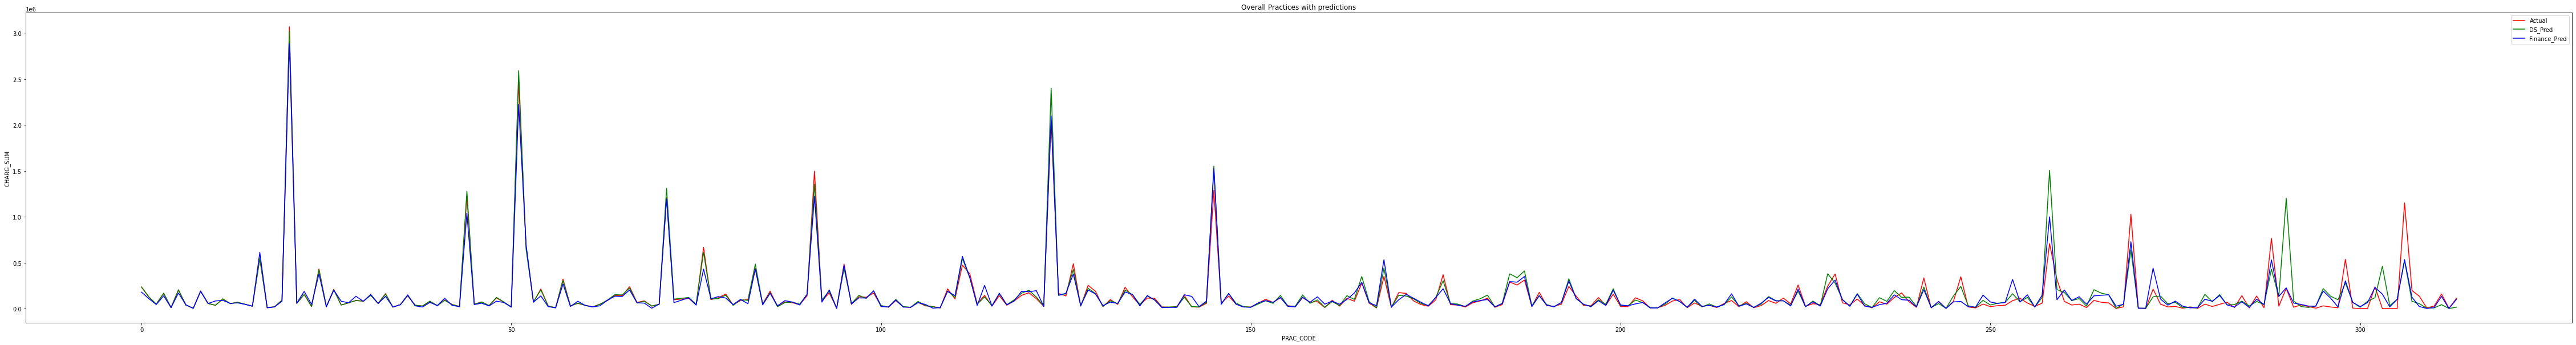

In [412]:
X =  all_pred_pay[['PRAC_CODE','CHARG_SUM','PREDICTED_CHARGES','FINANCE_CHARGES']]
# Assign variables to the y axis part of the curve
y = df0['CHARG_SUM']
z = df0['PREDICTED_CHARGES']
w = df0['FINANCE_CHARGES']
  
plt.figure(figsize=(80,10))
# Plotting both the curves simultaneously
plt.plot( y, color='r', label='Actual')
plt.plot(z, color='g', label='DS_Pred' )
plt.plot(w, color='b', label='Finance_Pred')

plt.xlabel("PRAC_CODE")
plt.ylabel("CHARG_SUM")
plt.title("Overall Practices with predictions")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

plt.show()

In [399]:
df1 = char80[['PRAC_CODE','CHARG_SUM','PREDICTED_CHARGES','FINANCE_CHARGES']]

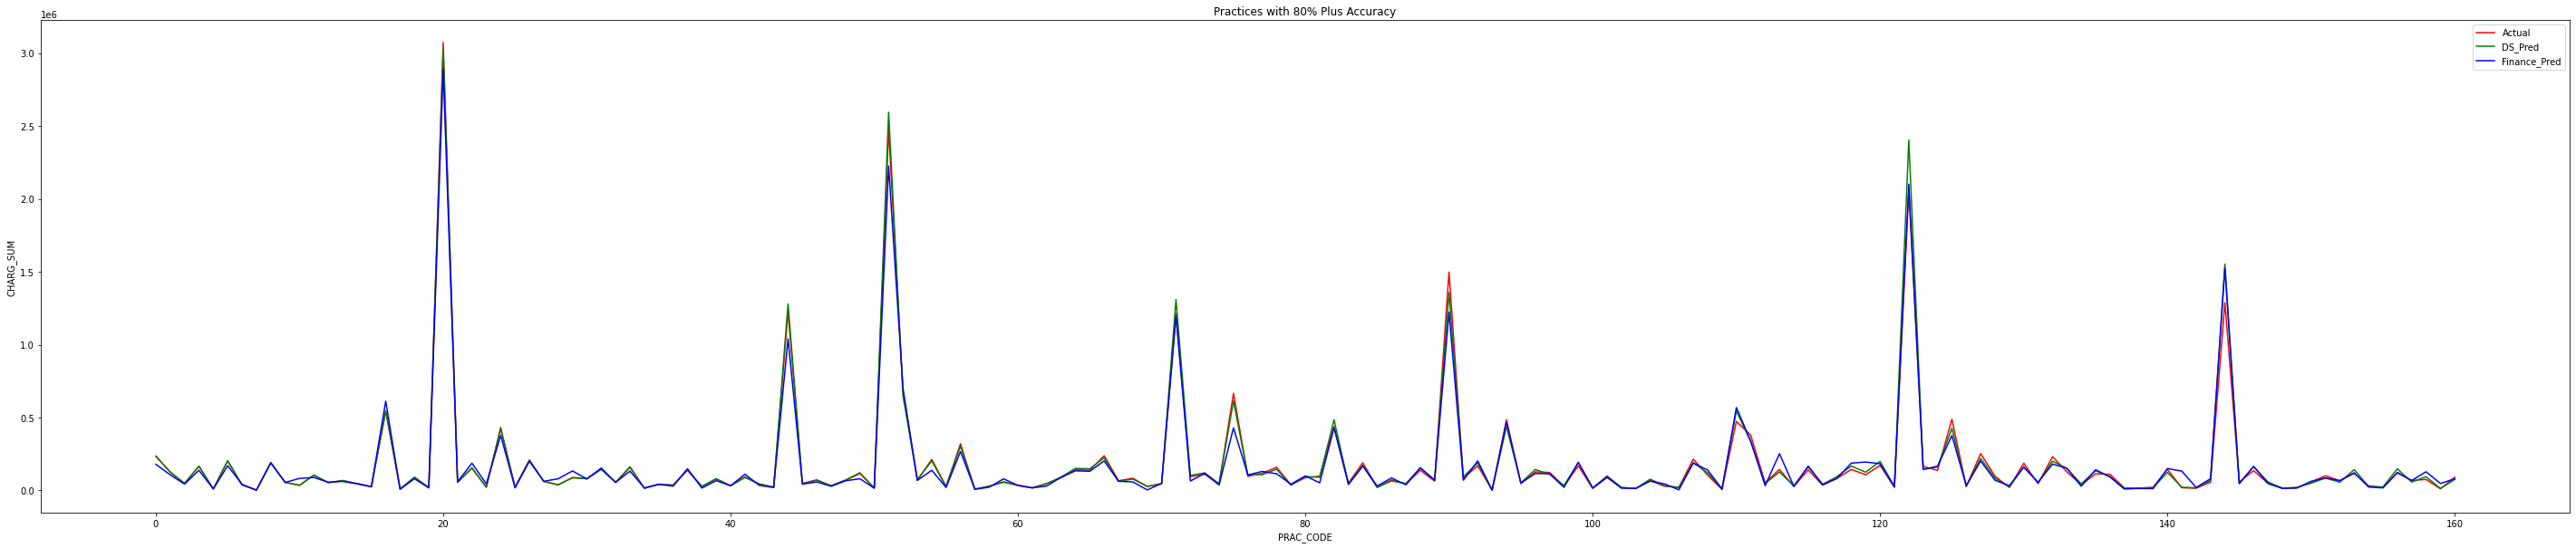

In [401]:
X =  all_pred_pay[['PRAC_CODE','CHARG_SUM','PREDICTED_CHARGES','FINANCE_CHARGES']]
# Assign variables to the y axis part of the curve
y = df1['CHARG_SUM']
z = df1['PREDICTED_CHARGES']
w = df1['FINANCE_CHARGES']
  
plt.figure(figsize=(80,10))
# Plotting both the curves simultaneously
plt.plot( y, color='r', label='Actual')
plt.plot(z, color='g', label='DS_Pred' )
plt.plot(w, color='b', label='Finance_Pred')

plt.xlabel("PRAC_CODE")
plt.ylabel("CHARG_SUM")
plt.title("Practices with 80% Plus Accuracy")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

plt.show()

In [402]:
df2 = char_60_80_Per[['PRAC_CODE','CHARG_SUM','PREDICTED_CHARGES','FINANCE_CHARGES']]

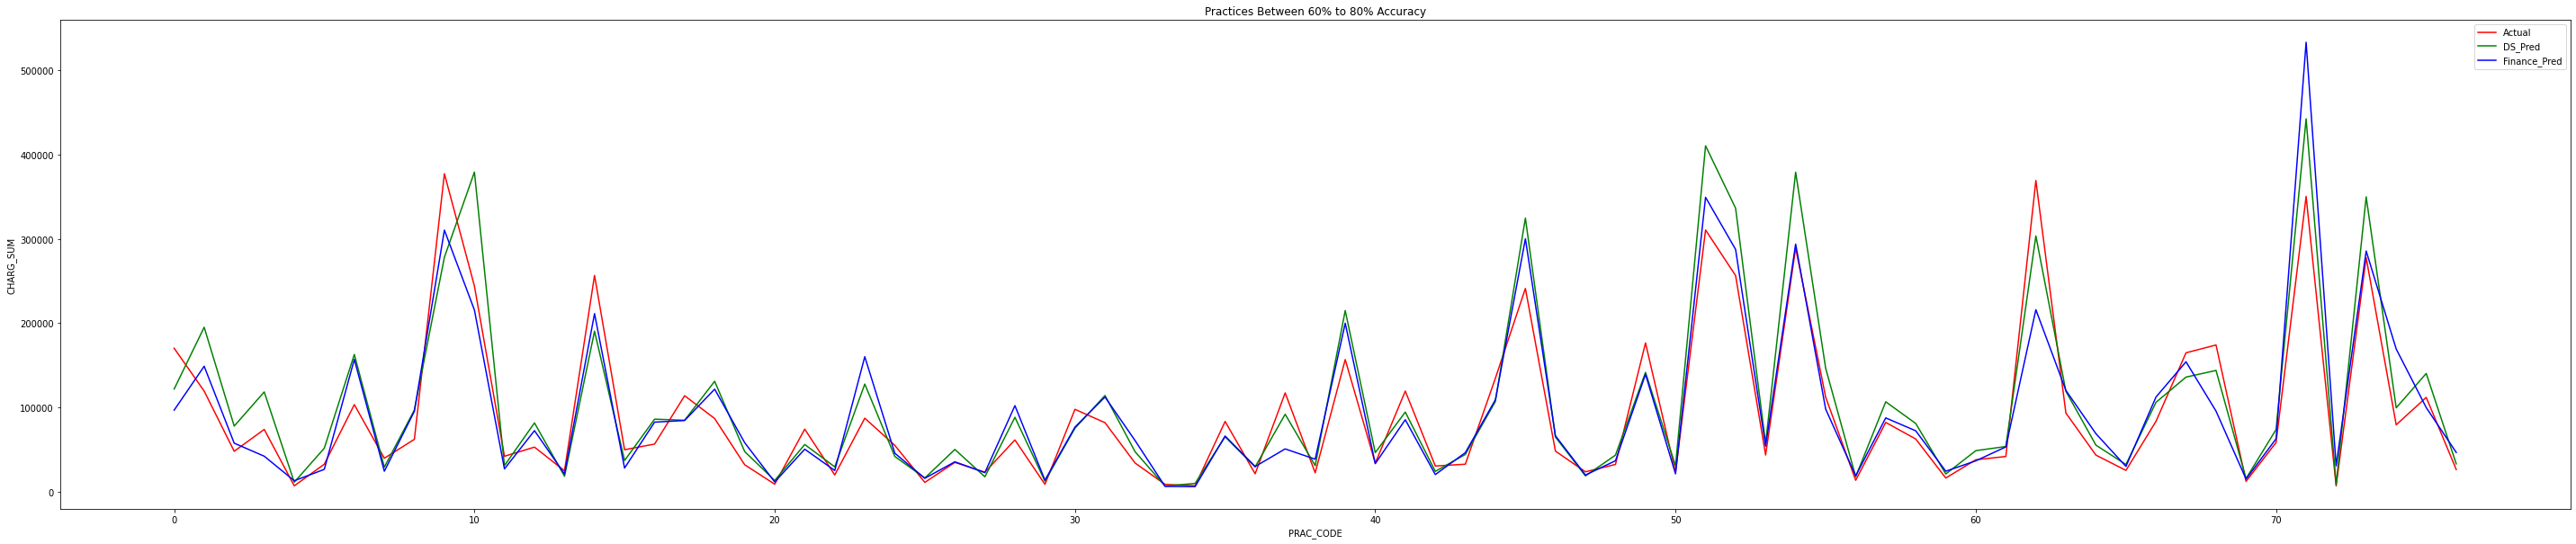

In [403]:
X =  all_pred_pay[['PRAC_CODE','CHARG_SUM','PREDICTED_CHARGES','FINANCE_CHARGES']]
# Assign variables to the y axis part of the curve
y = df2['CHARG_SUM']
z = df2['PREDICTED_CHARGES']
w = df2['FINANCE_CHARGES']
  
plt.figure(figsize=(80,10))
# Plotting both the curves simultaneously
plt.plot( y, color='r', label='Actual')
plt.plot(z, color='g', label='DS_Pred' )
plt.plot(w, color='b', label='Finance_Pred')

plt.xlabel("PRAC_CODE")
plt.ylabel("CHARG_SUM")
plt.title("Practices Between 60% to 80% Accuracy")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

plt.show()

In [405]:
df3 = char_b_60_fin[['PRAC_CODE','CHARG_SUM','PREDICTED_CHARGES','FINANCE_CHARGES']]

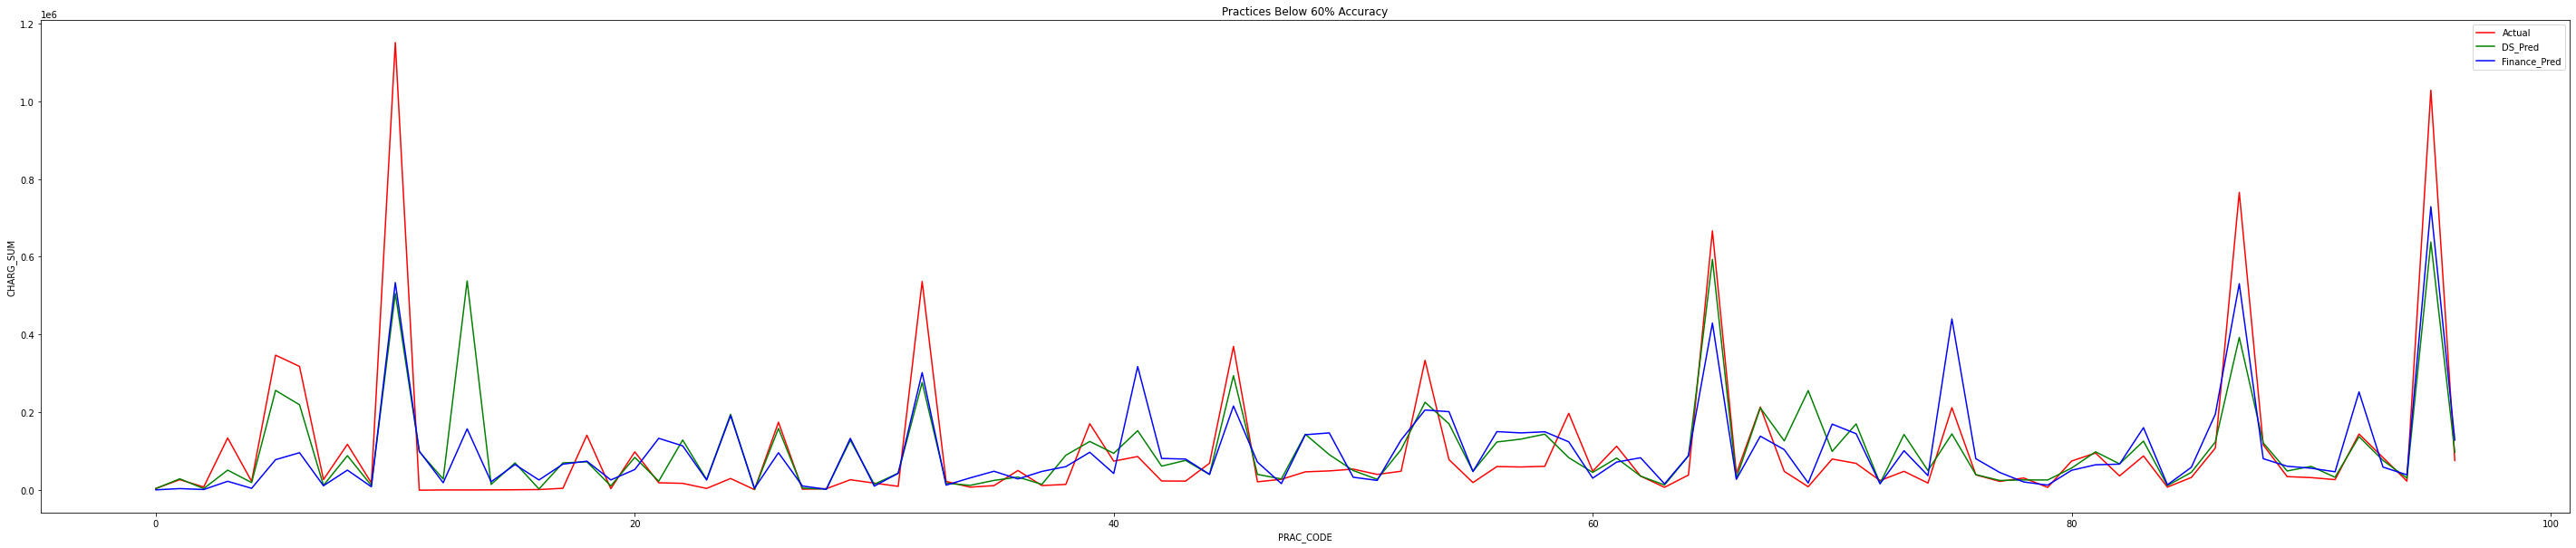

In [406]:
X =  all_pred_pay[['PRAC_CODE','CHARG_SUM','PREDICTED_CHARGES','FINANCE_CHARGES']]
# Assign variables to the y axis part of the curve
y = df3['CHARG_SUM']
z = df3['PREDICTED_CHARGES']
w = df3['FINANCE_CHARGES']
  
plt.figure(figsize=(80,10))
# Plotting both the curves simultaneously
plt.plot( y, color='r', label='Actual')
plt.plot(z, color='g', label='DS_Pred' )
plt.plot(w, color='b', label='Finance_Pred')

plt.xlabel("PRAC_CODE")
plt.ylabel("CHARG_SUM")
plt.title("Practices Below 60% Accuracy")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()


In [409]:
df4 = fin80[['PRAC_CODE','CHARG_SUM','PREDICTED_CHARGES','FINANCE_CHARGES']]

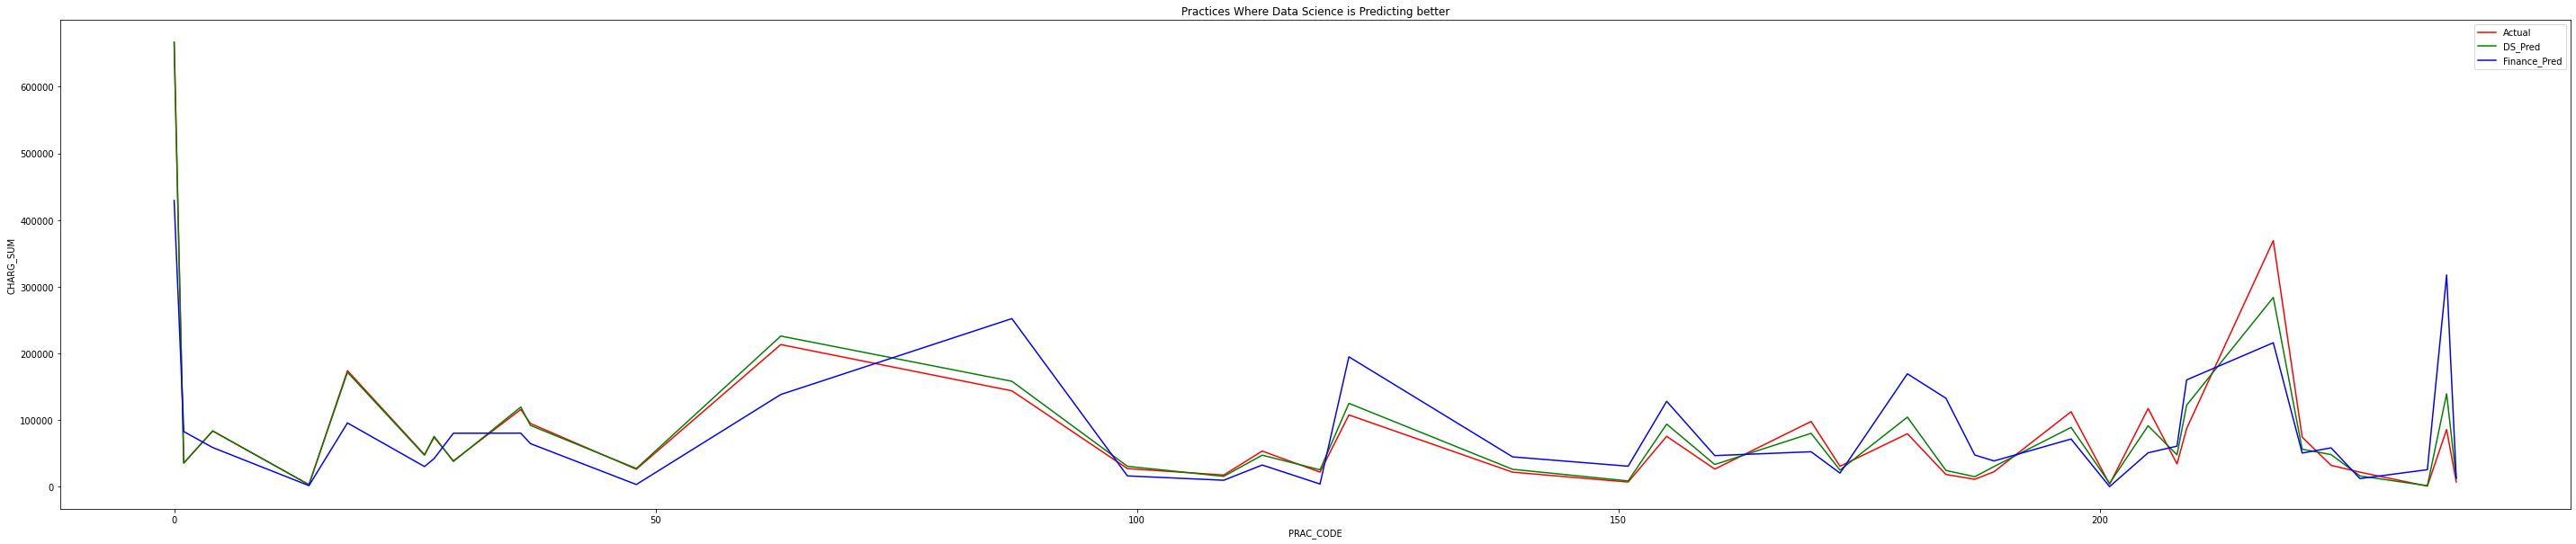

In [411]:
X =  all_pred_pay[['PRAC_CODE','CHARG_SUM','PREDICTED_CHARGES','FINANCE_CHARGES']]
# Assign variables to the y axis part of the curve
y = df4['CHARG_SUM']
z = df4['PREDICTED_CHARGES']
w = df4['FINANCE_CHARGES']
  
plt.figure(figsize=(80,10))
# Plotting both the curves simultaneously
plt.plot( y, color='r', label='Actual')
plt.plot(z, color='g', label='DS_Pred' )
plt.plot(w, color='b', label='Finance_Pred')

plt.xlabel("PRAC_CODE")
plt.ylabel("CHARG_SUM")
plt.title("Practices Where Data Science is Predicting better")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()


In [ ]:
02,09,16,21,25,49,71,74,75,83,84,88,96,103,110,118,138,177,193,195,198,211,212,221,231,233,234,248,253,259,279,294
303,310,335,346,362,364,386,400,416,472,481,504,528,559,563,568,577,588,600,603,607,613,615,627,642,648,650,652,
655,662,667,678,682,688,695,691,701,703,706,

In [ ]:
char_b_60.loc[char_b_60['PRAC_CODE'].isin([2910006,5110633,1011969,204,1011154,1011468,])]

In [108]:
char_b_60= all_pred_pay.loc[(all_pred_pay['VAR_CHAR_%']>40)]

In [109]:
data80= char_b_60.loc[char_b_60['FIN_VAR_CHAR_%']<=40]

In [110]:
data80 = data80.sort_values(by= 'FIN_VAR_CHAR_%')

In [111]:
# data80.to_csv("Finance_Better_Pred_Charg.csv")

In [112]:
fin_char_b_60 = all_pred_pay.loc[(all_pred_pay['FIN_VAR_CHAR_%']>40)]

In [113]:
fin80= fin_char_b_60.loc[fin_char_b_60['VAR_CHAR_%']<=40]

In [114]:
fin80 = fin80.sort_values(by = "VAR_CHAR_%")

In [115]:
# fin80.to_csv("DS_Better_Pred_Charg.csv")

In [116]:
print(f'Finance has total {len(fin_char_b_60)} practices under 60% accuracy out of which DS has {len(fin80)} practices with 60% plus accuracy')

Finance has total 97 practices under 60% accuracy out of which DS has 40 practices with 60% plus accuracy


In [117]:
print(f'DS has total {len(char_b_60)} practices under 60% accuracy out of which Finance has {len(data80)} practices with 60% plus accuracy')

DS has total 74 practices under 60% accuracy out of which Finance has 17 practices with 60% plus accuracy


In [ ]:
# Practices where DS is Predicting Better
1013258,2210004,256,5010174,6010109,1013454,1013523,5010122,6010154,1011453,1011774,1013361,5010007,2210138,1013512,
6010110,1013531,205,2110039,6010054,1013483,1010582,6010047,1010784,5010160,6210099,1013373,2210003,1011136,4010015,
2010008,2410014,2210028,6010111,1010836,1011570,2210007,5010116,1010840,5010146

In [ ]:
# Practices where Finance is Predicting Better
3010222,1013426,2110020,1010927,1012162,1010741,1010602,1910056,1011118,261,6010121,5010169,1011941,1013557,
5010100,6010006,2910012

In [157]:
data80.loc[data80['PRAC_CODE']==1013557]

,PRAC_CODE,MONTH,YEAR,CHARG_SUM,PREDICTED_CHARGES,FINANCE_CHARGES,VAR_CHAR_%,FIN_VAR_CHAR_%
259,1013557,1,2023,708880.97,1451212,1000000,51.2,29.1


In [158]:
data.loc[data['PRAC_CODE']==1013557]

,PRAC_CODE,MONTH,YEAR,CHARG_SUM,PREV_M_CHARG,PREV_2ND_M_CHARG,PAY_SUM,PREV_M_PAY,PREV_2ND_M_PAY,AGING_0_30,AGING_31_60,AGING_61_90,AGING_91_120,AGING_120_PLUS,PC_RATIO,PREV_3RD_M_CHARG,PREV_4TH_M_CHARG,PREV_5TH_M_CHARG,PREV_6TH_M_CHARG,PREV_7TH_M_CHARG,PREV_8TH_M_CHARG,PREV_9TH_M_CHARG,PREV_10TH_M_CHARG,PREV_11TH_M_CHARG,PREV_12TH_M_CHARG,PREV_3RD_M_PAY,PREV_4TH_M_PAY,PREV_5TH_M_PAY,PREV_6TH_M_PAY,PREV_7TH_M_PAY,PREV_8TH_M_PAY,PREV_9TH_M_PAY,PREV_10TH_M_PAY,PREV_11TH_M_PAY,PREV_12TH_M_PAY,PREV_M_AGING_0_30,PREV_2M_AGING_0_30,PREV_3M_AGING_0_30,PREV_4M_AGING_0_30,PREV_5M_AGING_0_30,PREV_6M_AGING_0_30,PREV_7M_AGING_0_30,PREV_8M_AGING_0_30,PREV_9M_AGING_0_30,PREV_10M_AGING_0_30,PREV_11M_AGING_0_30,PREV_12M_AGING_0_30,PREV_M_AGING_31_60,PREV_2M_AGING_31_60,PREV_3M_AGING_31_60,PREV_4M_AGING_31_60,PREV_5M_AGING_31_60,PREV_6M_AGING_31_60,PREV_7M_AGING_31_60,PREV_8M_AGING_31_60,PREV_9M_AGING_31_60,PREV_10M_AGING_31_60,PREV_11M_AGING_31_60,PREV_12M_AGING_31_60,PREV_M_AGING_61_90,PREV_2M_AGING_61_90,PREV_3M_AGING_61_90,PREV_4M_AGING_61_90,PREV_5M_AGING_61_90,PREV_6M_AGING_61_90,PREV_7M_AGING_61_90,PREV_8M_AGING_61_90,PREV_9M_AGING_61_90,PREV_10M_AGING_61_90,PREV_11M_AGING_61_90,PREV_12M_AGING_61_90,PREV_M_AGING_91_120,PREV_2M_AGING_91_120,PREV_3M_AGING_91_120,PREV_4M_AGING_91_120,PREV_5M_AGING_91_120,PREV_6M_AGING_91_120,PREV_7M_AGING_91_120,PREV_8M_AGING_91_120,PREV_9M_AGING_91_120,PREV_10M_AGING_91_120,PREV_11M_AGING_91_120,PREV_12M_AGING_91_120,PREV_M_AGING_120_PLUS,PREV_2M_AGING_120_PLUS,PREV_3M_AGING_120_PLUS,PREV_4M_AGING_120_PLUS,PREV_5M_AGING_120_PLUS,PREV_6M_AGING_120_PLUS,PREV_7M_AGING_120_PLUS,PREV_8M_AGING_120_PLUS,PREV_9M_AGING_120_PLUS,PREV_10M_AGING_120_PLUS,PREV_11M_AGING_120_PLUS,PREV_12M_AGING_120_PLUS,PREV_M_PC_RATIO,PREV_2M_PC_RATIO,PREV_3M_PC_RATIO,PREV_4M_PC_RATIO,PREV_5M_PC_RATIO,PREV_6M_PC_RATIO,PREV_7M_PC_RATIO,PREV_8M_PC_RATIO,PREV_9M_PC_RATIO,PREV_10M_PC_RATIO,PREV_11M_PC_RATIO,PREV_12M_PC_RATIO
9055,1013557,3,2022,1316832.24,0.00,0.00,165436.72,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.563234,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9056,1013557,4,2022,1435097.18,1316832.24,0.00,247289.37,165436.72,0.00,0.00,0.00,0.00,0.00,0.00,17.231542,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.563234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9057,1013557,5,2022,1658374.35,1435097.18,1316832.24,300304.79,247289.37,165436.72,0.00,0.00,0.00,0.00,0.00,18.108384,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.231542,12.563234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9058,1013557,6,2022,1380866.69,1658374.35,1435097.18,255005.40,300304.79,247289.37,0.00,0.00,0.00,0.00,0.00,18.467054,1316832.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,165436.72,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.

In [ ]:
for practice 3010222 our model is predicting as per trend but finance is predicting without followng trend
for practice 1013426 our model is predicting as per trend but finance is predicting without followng trend
for practice 2110020 for same month of previous years charges are almost same as per current months actual 
charges whereas other months have different trends
for practice 1010927 our model is predicting as per trend but finance is predicting without followng trend
for practice 1012162 

